In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(369744, 828)
(369744, 1)
validation
(50536, 828)
(50536, 1)
test
(51136, 828)
(51136, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 54s - loss: 0.3569 - STD: 1.5234e-04 - MAE: 0.5902

 4/37 [==>...........................] - ETA: 1s - loss: 0.1391 - STD: 5.0748e-04 - MAE: 0.3057 

 5/37 [===>..........................] - ETA: 1s - loss: 0.1136 - STD: 4.5365e-04 - MAE: 0.2604

 6/37 [===>..........................] - ETA: 1s - loss: 0.0975 - STD: 3.9922e-04 - MAE: 0.2336

 7/37 [====>.........................] - ETA: 1s - loss: 0.0867 - STD: 3.5236e-04 - MAE: 0.2169

 8/37 [=====>........................] - ETA: 1s - loss: 0.0790 - STD: 3.1367e-04 - MAE: 0.2062

 9/37 [======>.......................] - ETA: 1s - loss: 0.0733 - STD: 2.8180e-04 - MAE: 0.1987

10/37 [=======>......................] - ETA: 1s - loss: 0.0690 - STD: 2.5530e-04 - MAE: 0.1934

11/37 [=======>......................] - ETA: 1s - loss: 0.0655 - STD: 2.3304e-04 - MAE: 0.1892

12/37 [========>.....................] - ETA: 1s - loss: 0.0626 - STD: 2.1416e-04 - MAE: 0.1859

13/37 [=========>....................] - ETA: 1s - loss: 0.0602 - STD: 1.9799e-04 - MAE: 0.1832

14/37 [==========>...................] - ETA: 1s - loss: 0.0581 - STD: 1.8412e-04 - MAE: 0.1809

15/37 [===========>..................] - ETA: 1s - loss: 0.0563 - STD: 1.7217e-04 - MAE: 0.1788

16/37 [===========>..................] - ETA: 1s - loss: 0.0547 - STD: 1.6180e-04 - MAE: 0.1769

17/37 [============>.................] - ETA: 2s - loss: 0.0533 - STD: 1.5276e-04 - MAE: 0.1751

20/37 [===============>..............] - ETA: 1s - loss: 0.0495 - STD: 1.3154e-04 - MAE: 0.1701

22/37 [================>.............] - ETA: 1s - loss: 0.0474 - STD: 1.2099e-04 - MAE: 0.1666

23/37 [=================>............] - ETA: 1s - loss: 0.0463 - STD: 1.1653e-04 - MAE: 0.1648

24/37 [==================>...........] - ETA: 1s - loss: 0.0453 - STD: 1.1252e-04 - MAE: 0.1629

25/37 [===================>..........] - ETA: 1s - loss: 0.0443 - STD: 1.0891e-04 - MAE: 0.1608

26/37 [====================>.........] - ETA: 1s - loss: 0.0433 - STD: 1.0565e-04 - MAE: 0.1586

27/37 [====================>.........] - ETA: 0s - loss: 0.0423 - STD: 1.0269e-04 - MAE: 0.1563

28/37 [=====================>........] - ETA: 0s - loss: 0.0413 - STD: 9.9980e-05 - MAE: 0.1539

29/37 [======================>.......] - ETA: 0s - loss: 0.0403 - STD: 9.7486e-05 - MAE: 0.1515

30/37 [=======================>......] - ETA: 0s - loss: 0.0394 - STD: 9.5185e-05 - MAE: 0.1490

31/37 [========================>.....] - ETA: 0s - loss: 0.0384 - STD: 9.3022e-05 - MAE: 0.1466

32/37 [========================>.....] - ETA: 0s - loss: 0.0375 - STD: 9.0997e-05 - MAE: 0.1443

33/37 [=========================>....] - ETA: 0s - loss: 0.0366 - STD: 8.9078e-05 - MAE: 0.1422

34/37 [==========================>...] - ETA: 0s - loss: 0.0358 - STD: 8.7245e-05 - MAE: 0.1402

35/37 [===========================>..] - ETA: 0s - loss: 0.0350 - STD: 8.5494e-05 - MAE: 0.1385

36/37 [============================>.] - ETA: 0s - loss: 0.0343 - STD: 8.3809e-05 - MAE: 0.1370

37/37 [==============================] - ETA: 0s - loss: 0.0337 - STD: 8.2185e-05 - MAE: 0.1356

37/37 [==============================] - 5s 102ms/step - loss: 0.0337 - STD: 8.2185e-05 - MAE: 0.1356 - val_loss: 0.0113 - val_STD: 1.4340e-05 - val_MAE: 0.0821


Epoch 2/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0113 - STD: 2.2248e-05 - MAE: 0.0905

 2/37 [>.............................] - ETA: 2s - loss: 0.0112 - STD: 2.1391e-05 - MAE: 0.0902

 3/37 [=>............................] - ETA: 2s - loss: 0.0113 - STD: 2.0638e-05 - MAE: 0.0904

 4/37 [==>...........................] - ETA: 2s - loss: 0.0111 - STD: 1.9868e-05 - MAE: 0.0896

 5/37 [===>..........................] - ETA: 2s - loss: 0.0109 - STD: 1.9101e-05 - MAE: 0.0887

 6/37 [===>..........................] - ETA: 2s - loss: 0.0107 - STD: 1.8320e-05 - MAE: 0.0875

 7/37 [====>.........................] - ETA: 1s - loss: 0.0105 - STD: 1.7572e-05 - MAE: 0.0861

 8/37 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 1.6857e-05 - MAE: 0.0850

 9/37 [======>.......................] - ETA: 1s - loss: 0.0101 - STD: 1.6164e-05 - MAE: 0.0837

10/37 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 1.5511e-05 - MAE: 0.0826

11/37 [=======>......................] - ETA: 1s - loss: 0.0098 - STD: 1.4895e-05 - MAE: 0.0817

12/37 [========>.....................] - ETA: 1s - loss: 0.0098 - STD: 1.4335e-05 - MAE: 0.0809

13/37 [=========>....................] - ETA: 1s - loss: 0.0097 - STD: 1.3814e-05 - MAE: 0.0803

14/37 [==========>...................] - ETA: 1s - loss: 0.0097 - STD: 1.3333e-05 - MAE: 0.0797

15/37 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 1.2897e-05 - MAE: 0.0792

16/37 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 1.2498e-05 - MAE: 0.0789

17/37 [============>.................] - ETA: 1s - loss: 0.0096 - STD: 1.2139e-05 - MAE: 0.0785

18/37 [=============>................] - ETA: 1s - loss: 0.0096 - STD: 1.1810e-05 - MAE: 0.0781

19/37 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 1.1514e-05 - MAE: 0.0778

20/37 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 1.1254e-05 - MAE: 0.0775

21/37 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 1.1017e-05 - MAE: 0.0772

22/37 [================>.............] - ETA: 0s - loss: 0.0094 - STD: 1.0802e-05 - MAE: 0.0770

23/37 [=================>............] - ETA: 0s - loss: 0.0094 - STD: 1.0608e-05 - MAE: 0.0768

24/37 [==================>...........] - ETA: 0s - loss: 0.0093 - STD: 1.0433e-05 - MAE: 0.0766

25/37 [===================>..........] - ETA: 0s - loss: 0.0093 - STD: 1.0277e-05 - MAE: 0.0765

26/37 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 1.0133e-05 - MAE: 0.0764

27/37 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 1.0001e-05 - MAE: 0.0763

28/37 [=====================>........] - ETA: 0s - loss: 0.0093 - STD: 9.8786e-06 - MAE: 0.0763

29/37 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 9.7618e-06 - MAE: 0.0763

30/37 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.6539e-06 - MAE: 0.0763

31/37 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.5516e-06 - MAE: 0.0763

32/37 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.4532e-06 - MAE: 0.0763

33/37 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 9.3573e-06 - MAE: 0.0762

34/37 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 9.2617e-06 - MAE: 0.0762

35/37 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 9.1680e-06 - MAE: 0.0762

36/37 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 9.0760e-06 - MAE: 0.0761

37/37 [==============================] - ETA: 0s - loss: 0.0091 - STD: 8.9842e-06 - MAE: 0.0761

37/37 [==============================] - 3s 71ms/step - loss: 0.0091 - STD: 8.9842e-06 - MAE: 0.0761 - val_loss: 0.0087 - val_STD: 3.1714e-06 - val_MAE: 0.0686


Epoch 3/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 5.5787e-06 - MAE: 0.0736

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 5.5163e-06 - MAE: 0.0733

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 5.4693e-06 - MAE: 0.0733

 4/37 [==>...........................] - ETA: 2s - loss: 0.0087 - STD: 5.4172e-06 - MAE: 0.0734

 5/37 [===>..........................] - ETA: 2s - loss: 0.0087 - STD: 5.3705e-06 - MAE: 0.0733

 6/37 [===>..........................] - ETA: 2s - loss: 0.0087 - STD: 5.3405e-06 - MAE: 0.0732

 7/37 [====>.........................] - ETA: 1s - loss: 0.0087 - STD: 5.3049e-06 - MAE: 0.0732

 8/37 [=====>........................] - ETA: 1s - loss: 0.0087 - STD: 5.2745e-06 - MAE: 0.0731

 9/37 [======>.......................] - ETA: 1s - loss: 0.0087 - STD: 5.2555e-06 - MAE: 0.0731

10/37 [=======>......................] - ETA: 1s - loss: 0.0087 - STD: 5.2419e-06 - MAE: 0.0730

11/37 [=======>......................] - ETA: 1s - loss: 0.0087 - STD: 5.2254e-06 - MAE: 0.0730

12/37 [========>.....................] - ETA: 1s - loss: 0.0087 - STD: 5.2141e-06 - MAE: 0.0731

13/37 [=========>....................] - ETA: 1s - loss: 0.0087 - STD: 5.2090e-06 - MAE: 0.0730

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 5.2045e-06 - MAE: 0.0730

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.1980e-06 - MAE: 0.0730

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.1917e-06 - MAE: 0.0730

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 5.1902e-06 - MAE: 0.0730

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 5.1855e-06 - MAE: 0.0731

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 5.1828e-06 - MAE: 0.0731

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 5.1792e-06 - MAE: 0.0732

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 5.1747e-06 - MAE: 0.0732

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 5.1697e-06 - MAE: 0.0732

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 5.1604e-06 - MAE: 0.0732

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 5.1534e-06 - MAE: 0.0732

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 5.1458e-06 - MAE: 0.0732

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.1354e-06 - MAE: 0.0733

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.1255e-06 - MAE: 0.0733

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 5.1153e-06 - MAE: 0.0733

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 5.1066e-06 - MAE: 0.0733

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 5.0978e-06 - MAE: 0.0733

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.0882e-06 - MAE: 0.0733

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.0794e-06 - MAE: 0.0733

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 5.0706e-06 - MAE: 0.0733

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 5.0628e-06 - MAE: 0.0733

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 5.0544e-06 - MAE: 0.0733

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 5.0466e-06 - MAE: 0.0734

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 5.0395e-06 - MAE: 0.0734

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 5.0395e-06 - MAE: 0.0734 - val_loss: 0.0087 - val_STD: 2.2911e-06 - val_MAE: 0.0686


Epoch 4/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 4.8467e-06 - MAE: 0.0733

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 4.8306e-06 - MAE: 0.0737

 3/37 [=>............................] - ETA: 2s - loss: 0.0087 - STD: 4.8172e-06 - MAE: 0.0737

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 4.8056e-06 - MAE: 0.0736

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 4.8028e-06 - MAE: 0.0737

 6/37 [===>..........................] - ETA: 1s - loss: 0.0087 - STD: 4.8000e-06 - MAE: 0.0737

 7/37 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 4.7933e-06 - MAE: 0.0737

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 4.7882e-06 - MAE: 0.0737

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 4.7792e-06 - MAE: 0.0736

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 4.7741e-06 - MAE: 0.0736

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 4.7753e-06 - MAE: 0.0736

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 4.7732e-06 - MAE: 0.0736

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 4.7704e-06 - MAE: 0.0736

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 4.7671e-06 - MAE: 0.0735

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 4.7640e-06 - MAE: 0.0735

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 4.7635e-06 - MAE: 0.0735

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 4.7631e-06 - MAE: 0.0735

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 4.7653e-06 - MAE: 0.0735

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 4.7653e-06 - MAE: 0.0735

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 4.7672e-06 - MAE: 0.0735

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 4.7678e-06 - MAE: 0.0734

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 4.7713e-06 - MAE: 0.0735

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 4.7759e-06 - MAE: 0.0734

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 4.7820e-06 - MAE: 0.0734

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 4.7868e-06 - MAE: 0.0735

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 4.7907e-06 - MAE: 0.0734

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 4.7945e-06 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 4.7997e-06 - MAE: 0.0734

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 4.8062e-06 - MAE: 0.0734

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 4.8116e-06 - MAE: 0.0734

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 4.8188e-06 - MAE: 0.0734

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 4.8257e-06 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 4.8341e-06 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 4.8416e-06 - MAE: 0.0734

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 4.8501e-06 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 4.8595e-06 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 4.8692e-06 - MAE: 0.0735

37/37 [==============================] - 3s 70ms/step - loss: 0.0086 - STD: 4.8692e-06 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 3.0488e-06 - val_MAE: 0.0686


Epoch 5/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0087 - STD: 5.2692e-06 - MAE: 0.0741

 2/37 [>.............................] - ETA: 2s - loss: 0.0085 - STD: 5.3003e-06 - MAE: 0.0735

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 5.3044e-06 - MAE: 0.0736

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 5.3172e-06 - MAE: 0.0736

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 5.3472e-06 - MAE: 0.0736

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 5.3692e-06 - MAE: 0.0735

 7/37 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 5.3990e-06 - MAE: 0.0735

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 5.4226e-06 - MAE: 0.0735

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 5.4478e-06 - MAE: 0.0736

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 5.4743e-06 - MAE: 0.0736

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 5.4953e-06 - MAE: 0.0736

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 5.5199e-06 - MAE: 0.0737

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 5.5459e-06 - MAE: 0.0736

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 5.5719e-06 - MAE: 0.0736

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.6005e-06 - MAE: 0.0736

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.6303e-06 - MAE: 0.0736

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 5.6565e-06 - MAE: 0.0736

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 5.6799e-06 - MAE: 0.0736

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 5.7131e-06 - MAE: 0.0736

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 5.7420e-06 - MAE: 0.0736

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 5.7745e-06 - MAE: 0.0736

22/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 5.8083e-06 - MAE: 0.0736

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 5.8435e-06 - MAE: 0.0736

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 5.8783e-06 - MAE: 0.0736

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 5.9112e-06 - MAE: 0.0736

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.9481e-06 - MAE: 0.0736

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.9855e-06 - MAE: 0.0736

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 6.0220e-06 - MAE: 0.0735

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 6.0598e-06 - MAE: 0.0735

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 6.0964e-06 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 6.1358e-06 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 6.1755e-06 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 6.2166e-06 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 6.2565e-06 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 6.2985e-06 - MAE: 0.0734

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 6.3415e-06 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 6.3871e-06 - MAE: 0.0735

37/37 [==============================] - 3s 72ms/step - loss: 0.0086 - STD: 6.3871e-06 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 6.1122e-06 - val_MAE: 0.0686


Epoch 6/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0087 - STD: 8.0513e-06 - MAE: 0.0741

 2/37 [>.............................] - ETA: 2s - loss: 0.0087 - STD: 8.1482e-06 - MAE: 0.0739

 3/37 [=>............................] - ETA: 2s - loss: 0.0088 - STD: 8.2266e-06 - MAE: 0.0741

 4/37 [==>...........................] - ETA: 2s - loss: 0.0087 - STD: 8.2862e-06 - MAE: 0.0739

 5/37 [===>..........................] - ETA: 2s - loss: 0.0087 - STD: 8.3477e-06 - MAE: 0.0738

 6/37 [===>..........................] - ETA: 2s - loss: 0.0087 - STD: 8.4177e-06 - MAE: 0.0738

 7/37 [====>.........................] - ETA: 2s - loss: 0.0087 - STD: 8.4802e-06 - MAE: 0.0736

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 8.5453e-06 - MAE: 0.0735

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 8.6077e-06 - MAE: 0.0734

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 8.6826e-06 - MAE: 0.0734

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 8.7476e-06 - MAE: 0.0735

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 8.8167e-06 - MAE: 0.0735

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 8.8880e-06 - MAE: 0.0735

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 8.9567e-06 - MAE: 0.0734

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 9.0289e-06 - MAE: 0.0734

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 9.1045e-06 - MAE: 0.0734

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 9.1848e-06 - MAE: 0.0734

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 9.2598e-06 - MAE: 0.0733

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 9.3387e-06 - MAE: 0.0734

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 9.4182e-06 - MAE: 0.0734

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 9.4982e-06 - MAE: 0.0734

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 9.5796e-06 - MAE: 0.0734

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 9.6607e-06 - MAE: 0.0735

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 9.7421e-06 - MAE: 0.0735

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 9.8299e-06 - MAE: 0.0735

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 9.9198e-06 - MAE: 0.0735

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 1.0011e-05 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 1.0100e-05 - MAE: 0.0735

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 1.0191e-05 - MAE: 0.0735

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 1.0286e-05 - MAE: 0.0736

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 1.0377e-05 - MAE: 0.0736

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 1.0473e-05 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 1.0569e-05 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 1.0662e-05 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 1.0763e-05 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 1.0863e-05 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 1.0964e-05 - MAE: 0.0735

37/37 [==============================] - 3s 70ms/step - loss: 0.0086 - STD: 1.0964e-05 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 1.2252e-05 - val_MAE: 0.0685


Epoch 7/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 1.5048e-05 - MAE: 0.0737

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 1.5073e-05 - MAE: 0.0735

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 1.5162e-05 - MAE: 0.0732

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 1.5310e-05 - MAE: 0.0733

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 1.5450e-05 - MAE: 0.0732

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 1.5612e-05 - MAE: 0.0734

 7/37 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 1.5765e-05 - MAE: 0.0735

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 1.5942e-05 - MAE: 0.0736

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 1.6078e-05 - MAE: 0.0735

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 1.6217e-05 - MAE: 0.0735

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 1.6360e-05 - MAE: 0.0734

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 1.6511e-05 - MAE: 0.0734

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 1.6671e-05 - MAE: 0.0734

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 1.6840e-05 - MAE: 0.0735

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 1.7007e-05 - MAE: 0.0734

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 1.7162e-05 - MAE: 0.0734

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 1.7352e-05 - MAE: 0.0734

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 1.7532e-05 - MAE: 0.0734

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 1.7707e-05 - MAE: 0.0734

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 1.7884e-05 - MAE: 0.0734

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 1.8073e-05 - MAE: 0.0734

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 1.8247e-05 - MAE: 0.0734

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 1.8432e-05 - MAE: 0.0734

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 1.8632e-05 - MAE: 0.0734

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 1.8825e-05 - MAE: 0.0735

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 1.9013e-05 - MAE: 0.0734

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 1.9214e-05 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 1.9412e-05 - MAE: 0.0734

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 1.9619e-05 - MAE: 0.0735

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 1.9823e-05 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 2.0048e-05 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 2.0277e-05 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 2.0499e-05 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 2.0720e-05 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 2.0942e-05 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 2.1177e-05 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 2.1420e-05 - MAE: 0.0735

37/37 [==============================] - 3s 69ms/step - loss: 0.0086 - STD: 2.1420e-05 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 2.5670e-05 - val_MAE: 0.0685


Epoch 8/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0085 - STD: 3.0431e-05 - MAE: 0.0731

 2/37 [>.............................] - ETA: 2s - loss: 0.0085 - STD: 3.0914e-05 - MAE: 0.0730

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 3.1174e-05 - MAE: 0.0732

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 3.1612e-05 - MAE: 0.0734

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 3.2029e-05 - MAE: 0.0735

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 3.2366e-05 - MAE: 0.0735

 7/37 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 3.2660e-05 - MAE: 0.0735

 8/37 [=====>........................] - ETA: 2s - loss: 0.0086 - STD: 3.3055e-05 - MAE: 0.0736

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 3.3430e-05 - MAE: 0.0736

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 3.3772e-05 - MAE: 0.0736

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 3.4121e-05 - MAE: 0.0736

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 3.4488e-05 - MAE: 0.0736

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 3.4897e-05 - MAE: 0.0736

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 3.5290e-05 - MAE: 0.0735

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 3.5667e-05 - MAE: 0.0734

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 3.6040e-05 - MAE: 0.0734

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 3.6429e-05 - MAE: 0.0734

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 3.6843e-05 - MAE: 0.0734

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 3.7245e-05 - MAE: 0.0734

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 3.7626e-05 - MAE: 0.0734

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 3.8016e-05 - MAE: 0.0733

22/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 3.8432e-05 - MAE: 0.0733

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 3.8837e-05 - MAE: 0.0733

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 3.9291e-05 - MAE: 0.0733

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 3.9746e-05 - MAE: 0.0733

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 4.0203e-05 - MAE: 0.0733

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 4.0669e-05 - MAE: 0.0734

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 4.1148e-05 - MAE: 0.0733

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 4.1626e-05 - MAE: 0.0734

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 4.2123e-05 - MAE: 0.0733

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 4.2625e-05 - MAE: 0.0734

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 4.3127e-05 - MAE: 0.0734

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 4.3636e-05 - MAE: 0.0734

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 4.4138e-05 - MAE: 0.0734

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 4.4647e-05 - MAE: 0.0734

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 4.5148e-05 - MAE: 0.0734

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 4.5677e-05 - MAE: 0.0735

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 4.5677e-05 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 5.5025e-05 - val_MAE: 0.0685


Epoch 9/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 6.5226e-05 - MAE: 0.0730

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 6.5810e-05 - MAE: 0.0735

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 6.6720e-05 - MAE: 0.0735

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 6.7581e-05 - MAE: 0.0732

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 6.8594e-05 - MAE: 0.0735

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 6.9359e-05 - MAE: 0.0734

 7/37 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 7.0024e-05 - MAE: 0.0734

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 7.0701e-05 - MAE: 0.0735

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 7.1569e-05 - MAE: 0.0735

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 7.2413e-05 - MAE: 0.0735

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 7.3168e-05 - MAE: 0.0735

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 7.4010e-05 - MAE: 0.0735

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 7.4891e-05 - MAE: 0.0735

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 7.5768e-05 - MAE: 0.0735

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 7.6599e-05 - MAE: 0.0735

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 7.7477e-05 - MAE: 0.0736

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 7.8402e-05 - MAE: 0.0735

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 7.9302e-05 - MAE: 0.0735

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 8.0123e-05 - MAE: 0.0735

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 8.1010e-05 - MAE: 0.0734

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 8.1959e-05 - MAE: 0.0735

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 8.2951e-05 - MAE: 0.0735

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 8.3948e-05 - MAE: 0.0735

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 8.4988e-05 - MAE: 0.0735

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 8.6036e-05 - MAE: 0.0735

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 8.7042e-05 - MAE: 0.0735

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 8.8090e-05 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 8.9251e-05 - MAE: 0.0735

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 9.0375e-05 - MAE: 0.0735

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 9.1521e-05 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 9.2737e-05 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 9.3963e-05 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 9.5189e-05 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 9.6493e-05 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 9.7770e-05 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 9.9091e-05 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 1.0043e-04 - MAE: 0.0735

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 1.0043e-04 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 1.2702e-04 - val_MAE: 0.0685


Epoch 10/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 1.5228e-04 - MAE: 0.0731

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 1.5520e-04 - MAE: 0.0732

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 1.5661e-04 - MAE: 0.0733

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 1.5857e-04 - MAE: 0.0732

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 1.6106e-04 - MAE: 0.0733

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 1.6356e-04 - MAE: 0.0733

 7/37 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 1.6563e-04 - MAE: 0.0733

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 1.6795e-04 - MAE: 0.0734

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 1.7009e-04 - MAE: 0.0734

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 1.7266e-04 - MAE: 0.0734

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 1.7530e-04 - MAE: 0.0734

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 1.7771e-04 - MAE: 0.0733

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 1.8023e-04 - MAE: 0.0734

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 1.8271e-04 - MAE: 0.0733

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 1.8554e-04 - MAE: 0.0733

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 1.8838e-04 - MAE: 0.0733

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 1.9104e-04 - MAE: 0.0733

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 1.9400e-04 - MAE: 0.0733

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 1.9700e-04 - MAE: 0.0733

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 2.0013e-04 - MAE: 0.0733

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 2.0315e-04 - MAE: 0.0733

22/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 2.0643e-04 - MAE: 0.0733

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 2.0963e-04 - MAE: 0.0733

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 2.1304e-04 - MAE: 0.0733

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 2.1668e-04 - MAE: 0.0733

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 2.2023e-04 - MAE: 0.0734

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 2.2406e-04 - MAE: 0.0734

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 2.2789e-04 - MAE: 0.0734

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 2.3183e-04 - MAE: 0.0734

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 2.3596e-04 - MAE: 0.0734

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 2.4023e-04 - MAE: 0.0734

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 2.4462e-04 - MAE: 0.0734

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 2.4892e-04 - MAE: 0.0734

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 2.5351e-04 - MAE: 0.0734

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 2.5824e-04 - MAE: 0.0734

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 2.6313e-04 - MAE: 0.0734

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 2.6807e-04 - MAE: 0.0734

37/37 [==============================] - 3s 72ms/step - loss: 0.0086 - STD: 2.6807e-04 - MAE: 0.0734 - val_loss: 0.0087 - val_STD: 3.7947e-04 - val_MAE: 0.0684


Epoch 11/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0084 - STD: 4.6352e-04 - MAE: 0.0724

 2/37 [>.............................] - ETA: 2s - loss: 0.0084 - STD: 4.7054e-04 - MAE: 0.0727

 3/37 [=>............................] - ETA: 2s - loss: 0.0085 - STD: 4.7896e-04 - MAE: 0.0728

 4/37 [==>...........................] - ETA: 2s - loss: 0.0085 - STD: 4.8635e-04 - MAE: 0.0729

 5/37 [===>..........................] - ETA: 2s - loss: 0.0085 - STD: 4.9535e-04 - MAE: 0.0731

 6/37 [===>..........................] - ETA: 1s - loss: 0.0086 - STD: 5.0277e-04 - MAE: 0.0732

 7/37 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 5.1098e-04 - MAE: 0.0731

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 5.1984e-04 - MAE: 0.0732

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 5.2909e-04 - MAE: 0.0733

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 5.3882e-04 - MAE: 0.0733

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 5.4868e-04 - MAE: 0.0731

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 5.5958e-04 - MAE: 0.0732

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 5.7021e-04 - MAE: 0.0733

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 5.8108e-04 - MAE: 0.0733

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.9153e-04 - MAE: 0.0733

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 6.0304e-04 - MAE: 0.0734

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 6.1415e-04 - MAE: 0.0733

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 6.2628e-04 - MAE: 0.0734

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 6.3856e-04 - MAE: 0.0733

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 6.5108e-04 - MAE: 0.0733

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 6.6394e-04 - MAE: 0.0733

22/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 6.7702e-04 - MAE: 0.0733

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 6.8964e-04 - MAE: 0.0733

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 7.0291e-04 - MAE: 0.0733

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 7.1663e-04 - MAE: 0.0733

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 7.3054e-04 - MAE: 0.0733

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 7.4512e-04 - MAE: 0.0732

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 7.5997e-04 - MAE: 0.0732

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 7.7524e-04 - MAE: 0.0732

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 7.9073e-04 - MAE: 0.0733

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 8.0717e-04 - MAE: 0.0733

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 8.2393e-04 - MAE: 0.0733

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 8.4116e-04 - MAE: 0.0733

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 8.5849e-04 - MAE: 0.0732

35/37 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 8.7638e-04 - MAE: 0.0732

36/37 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 8.9513e-04 - MAE: 0.0732

37/37 [==============================] - ETA: 0s - loss: 0.0085 - STD: 9.1423e-04 - MAE: 0.0732

37/37 [==============================] - 3s 73ms/step - loss: 0.0085 - STD: 9.1423e-04 - MAE: 0.0732 - val_loss: 0.0086 - val_STD: 0.0013 - val_MAE: 0.0680


Epoch 12/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0087 - STD: 0.0017 - MAE: 0.0742

 2/37 [>.............................] - ETA: 2s - loss: 0.0087 - STD: 0.0017 - MAE: 0.0739

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 0.0017 - MAE: 0.0735

 4/37 [==>...........................] - ETA: 2s - loss: 0.0085 - STD: 0.0017 - MAE: 0.0731

 5/37 [===>..........................] - ETA: 2s - loss: 0.0085 - STD: 0.0018 - MAE: 0.0730

 6/37 [===>..........................] - ETA: 2s - loss: 0.0085 - STD: 0.0018 - MAE: 0.0730

 7/37 [====>.........................] - ETA: 2s - loss: 0.0085 - STD: 0.0018 - MAE: 0.0729

 8/37 [=====>........................] - ETA: 1s - loss: 0.0085 - STD: 0.0019 - MAE: 0.0729

 9/37 [======>.......................] - ETA: 1s - loss: 0.0085 - STD: 0.0019 - MAE: 0.0729

10/37 [=======>......................] - ETA: 1s - loss: 0.0085 - STD: 0.0019 - MAE: 0.0729

11/37 [=======>......................] - ETA: 1s - loss: 0.0085 - STD: 0.0020 - MAE: 0.0728

12/37 [========>.....................] - ETA: 1s - loss: 0.0085 - STD: 0.0020 - MAE: 0.0729

13/37 [=========>....................] - ETA: 1s - loss: 0.0085 - STD: 0.0020 - MAE: 0.0729

14/37 [==========>...................] - ETA: 1s - loss: 0.0085 - STD: 0.0021 - MAE: 0.0729

15/37 [===========>..................] - ETA: 1s - loss: 0.0085 - STD: 0.0021 - MAE: 0.0730

16/37 [===========>..................] - ETA: 1s - loss: 0.0085 - STD: 0.0022 - MAE: 0.0730

17/37 [============>.................] - ETA: 1s - loss: 0.0085 - STD: 0.0022 - MAE: 0.0729

18/37 [=============>................] - ETA: 1s - loss: 0.0084 - STD: 0.0023 - MAE: 0.0728

19/37 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.0023 - MAE: 0.0728

20/37 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0023 - MAE: 0.0728

21/37 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0024 - MAE: 0.0728

22/37 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0024 - MAE: 0.0727

23/37 [=================>............] - ETA: 0s - loss: 0.0084 - STD: 0.0025 - MAE: 0.0727

24/37 [==================>...........] - ETA: 0s - loss: 0.0084 - STD: 0.0025 - MAE: 0.0727

25/37 [===================>..........] - ETA: 0s - loss: 0.0084 - STD: 0.0026 - MAE: 0.0728

26/37 [====================>.........] - ETA: 0s - loss: 0.0084 - STD: 0.0026 - MAE: 0.0728

27/37 [====================>.........] - ETA: 0s - loss: 0.0084 - STD: 0.0027 - MAE: 0.0727

28/37 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.0028 - MAE: 0.0727

29/37 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.0028 - MAE: 0.0727

30/37 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0029 - MAE: 0.0727

31/37 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0029 - MAE: 0.0727

32/37 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0030 - MAE: 0.0726

33/37 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.0031 - MAE: 0.0726

34/37 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.0031 - MAE: 0.0726

35/37 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.0032 - MAE: 0.0726

36/37 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.0033 - MAE: 0.0726

37/37 [==============================] - ETA: 0s - loss: 0.0084 - STD: 0.0033 - MAE: 0.0726

37/37 [==============================] - 3s 72ms/step - loss: 0.0084 - STD: 0.0033 - MAE: 0.0726 - val_loss: 0.0082 - val_STD: 0.0048 - val_MAE: 0.0667


Epoch 13/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0082 - STD: 0.0061 - MAE: 0.0716

 2/37 [>.............................] - ETA: 2s - loss: 0.0082 - STD: 0.0062 - MAE: 0.0715

 3/37 [=>............................] - ETA: 2s - loss: 0.0082 - STD: 0.0063 - MAE: 0.0716

 4/37 [==>...........................] - ETA: 2s - loss: 0.0082 - STD: 0.0064 - MAE: 0.0717

 5/37 [===>..........................] - ETA: 2s - loss: 0.0082 - STD: 0.0065 - MAE: 0.0718

 6/37 [===>..........................] - ETA: 2s - loss: 0.0082 - STD: 0.0066 - MAE: 0.0717

 7/37 [====>.........................] - ETA: 1s - loss: 0.0081 - STD: 0.0067 - MAE: 0.0716

 8/37 [=====>........................] - ETA: 1s - loss: 0.0081 - STD: 0.0069 - MAE: 0.0716

 9/37 [======>.......................] - ETA: 1s - loss: 0.0081 - STD: 0.0070 - MAE: 0.0716

10/37 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0071 - MAE: 0.0716

11/37 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0072 - MAE: 0.0715

12/37 [========>.....................] - ETA: 1s - loss: 0.0081 - STD: 0.0074 - MAE: 0.0714

13/37 [=========>....................] - ETA: 1s - loss: 0.0081 - STD: 0.0075 - MAE: 0.0714

14/37 [==========>...................] - ETA: 1s - loss: 0.0081 - STD: 0.0076 - MAE: 0.0714

15/37 [===========>..................] - ETA: 1s - loss: 0.0081 - STD: 0.0078 - MAE: 0.0714

16/37 [===========>..................] - ETA: 1s - loss: 0.0081 - STD: 0.0079 - MAE: 0.0713

17/37 [============>.................] - ETA: 1s - loss: 0.0081 - STD: 0.0080 - MAE: 0.0713

18/37 [=============>................] - ETA: 1s - loss: 0.0081 - STD: 0.0082 - MAE: 0.0713

19/37 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.0084 - MAE: 0.0713

20/37 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0085 - MAE: 0.0713

21/37 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.0087 - MAE: 0.0712

22/37 [================>.............] - ETA: 0s - loss: 0.0080 - STD: 0.0088 - MAE: 0.0712

23/37 [=================>............] - ETA: 0s - loss: 0.0080 - STD: 0.0090 - MAE: 0.0712

24/37 [==================>...........] - ETA: 0s - loss: 0.0080 - STD: 0.0092 - MAE: 0.0711

25/37 [===================>..........] - ETA: 0s - loss: 0.0080 - STD: 0.0093 - MAE: 0.0711

26/37 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.0095 - MAE: 0.0710

27/37 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.0097 - MAE: 0.0710

28/37 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0098 - MAE: 0.0710

29/37 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.0100 - MAE: 0.0709

30/37 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0102 - MAE: 0.0709

31/37 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0104 - MAE: 0.0708

32/37 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0106 - MAE: 0.0707

33/37 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0108 - MAE: 0.0707

34/37 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0109 - MAE: 0.0707

35/37 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0111 - MAE: 0.0707

36/37 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0113 - MAE: 0.0706

37/37 [==============================] - ETA: 0s - loss: 0.0079 - STD: 0.0115 - MAE: 0.0706

37/37 [==============================] - 2s 66ms/step - loss: 0.0079 - STD: 0.0115 - MAE: 0.0706 - val_loss: 0.0074 - val_STD: 0.0150 - val_MAE: 0.0633


Epoch 14/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.0188 - MAE: 0.0682

 2/37 [>.............................] - ETA: 2s - loss: 0.0073 - STD: 0.0192 - MAE: 0.0683

 3/37 [=>............................] - ETA: 2s - loss: 0.0073 - STD: 0.0196 - MAE: 0.0683

 4/37 [==>...........................] - ETA: 2s - loss: 0.0073 - STD: 0.0199 - MAE: 0.0682

 5/37 [===>..........................] - ETA: 1s - loss: 0.0073 - STD: 0.0202 - MAE: 0.0682

 6/37 [===>..........................] - ETA: 1s - loss: 0.0073 - STD: 0.0204 - MAE: 0.0683

 7/37 [====>.........................] - ETA: 1s - loss: 0.0074 - STD: 0.0206 - MAE: 0.0684

 8/37 [=====>........................] - ETA: 1s - loss: 0.0074 - STD: 0.0208 - MAE: 0.0685

 9/37 [======>.......................] - ETA: 1s - loss: 0.0074 - STD: 0.0211 - MAE: 0.0685

10/37 [=======>......................] - ETA: 1s - loss: 0.0074 - STD: 0.0213 - MAE: 0.0685

11/37 [=======>......................] - ETA: 1s - loss: 0.0074 - STD: 0.0216 - MAE: 0.0685

12/37 [========>.....................] - ETA: 1s - loss: 0.0074 - STD: 0.0218 - MAE: 0.0684

13/37 [=========>....................] - ETA: 1s - loss: 0.0074 - STD: 0.0221 - MAE: 0.0684

14/37 [==========>...................] - ETA: 1s - loss: 0.0074 - STD: 0.0223 - MAE: 0.0684

15/37 [===========>..................] - ETA: 1s - loss: 0.0074 - STD: 0.0225 - MAE: 0.0683

16/37 [===========>..................] - ETA: 1s - loss: 0.0073 - STD: 0.0228 - MAE: 0.0682

17/37 [============>.................] - ETA: 1s - loss: 0.0073 - STD: 0.0230 - MAE: 0.0681

18/37 [=============>................] - ETA: 1s - loss: 0.0073 - STD: 0.0232 - MAE: 0.0681

19/37 [==============>...............] - ETA: 1s - loss: 0.0073 - STD: 0.0235 - MAE: 0.0680

20/37 [===============>..............] - ETA: 0s - loss: 0.0073 - STD: 0.0237 - MAE: 0.0678

21/37 [================>.............] - ETA: 0s - loss: 0.0073 - STD: 0.0239 - MAE: 0.0678

22/37 [================>.............] - ETA: 0s - loss: 0.0073 - STD: 0.0241 - MAE: 0.0678

23/37 [=================>............] - ETA: 0s - loss: 0.0072 - STD: 0.0243 - MAE: 0.0677

24/37 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0245 - MAE: 0.0677

25/37 [===================>..........] - ETA: 0s - loss: 0.0072 - STD: 0.0247 - MAE: 0.0676

26/37 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0249 - MAE: 0.0676

27/37 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0251 - MAE: 0.0676

28/37 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0253 - MAE: 0.0675

29/37 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0255 - MAE: 0.0675

30/37 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0257 - MAE: 0.0674

31/37 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0259 - MAE: 0.0673

32/37 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0261 - MAE: 0.0673

33/37 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0263 - MAE: 0.0672

34/37 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0265 - MAE: 0.0672

35/37 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0266 - MAE: 0.0671

36/37 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0268 - MAE: 0.0671

37/37 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0269 - MAE: 0.0671

37/37 [==============================] - 2s 63ms/step - loss: 0.0071 - STD: 0.0269 - MAE: 0.0671 - val_loss: 0.0067 - val_STD: 0.0255 - val_MAE: 0.0590


Epoch 15/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0067 - STD: 0.0327 - MAE: 0.0644

 2/37 [>.............................] - ETA: 2s - loss: 0.0067 - STD: 0.0330 - MAE: 0.0644

 3/37 [=>............................] - ETA: 2s - loss: 0.0067 - STD: 0.0332 - MAE: 0.0645

 4/37 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.0333 - MAE: 0.0647

 5/37 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0334 - MAE: 0.0647

 6/37 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0336 - MAE: 0.0646

 7/37 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.0337 - MAE: 0.0646

 8/37 [=====>........................] - ETA: 1s - loss: 0.0067 - STD: 0.0338 - MAE: 0.0646

 9/37 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.0339 - MAE: 0.0645

10/37 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.0340 - MAE: 0.0646

11/37 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.0341 - MAE: 0.0646

12/37 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.0342 - MAE: 0.0645

13/37 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0343 - MAE: 0.0644

14/37 [==========>...................] - ETA: 1s - loss: 0.0067 - STD: 0.0344 - MAE: 0.0644

15/37 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.0345 - MAE: 0.0644

16/37 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.0346 - MAE: 0.0643

17/37 [============>.................] - ETA: 1s - loss: 0.0067 - STD: 0.0347 - MAE: 0.0643

18/37 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.0348 - MAE: 0.0643

19/37 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0349 - MAE: 0.0642

20/37 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0350 - MAE: 0.0641

21/37 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0352 - MAE: 0.0641

22/37 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0353 - MAE: 0.0640

23/37 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0354 - MAE: 0.0640

24/37 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0355 - MAE: 0.0639

25/37 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0355 - MAE: 0.0638

26/37 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0356 - MAE: 0.0637

27/37 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0356 - MAE: 0.0636

28/37 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0357 - MAE: 0.0636

29/37 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0358 - MAE: 0.0635

30/37 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0359 - MAE: 0.0634

31/37 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0360 - MAE: 0.0633

32/37 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0361 - MAE: 0.0632

33/37 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0362 - MAE: 0.0631

34/37 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0364 - MAE: 0.0630

35/37 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0364 - MAE: 0.0629

36/37 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0365 - MAE: 0.0629

37/37 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0366 - MAE: 0.0627

37/37 [==============================] - 2s 62ms/step - loss: 0.0064 - STD: 0.0366 - MAE: 0.0627 - val_loss: 0.0057 - val_STD: 0.0330 - val_MAE: 0.0542


Epoch 16/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0056 - STD: 0.0409 - MAE: 0.0576

 2/37 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0418 - MAE: 0.0582

 3/37 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0417 - MAE: 0.0579

 4/37 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0421 - MAE: 0.0579

 5/37 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0425 - MAE: 0.0580

 6/37 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0423 - MAE: 0.0576

 7/37 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0429 - MAE: 0.0580

 8/37 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0429 - MAE: 0.0578

 9/37 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0432 - MAE: 0.0577

10/37 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0437 - MAE: 0.0578

11/37 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0438 - MAE: 0.0576

12/37 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0442 - MAE: 0.0575

13/37 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0445 - MAE: 0.0574

14/37 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0447 - MAE: 0.0573

15/37 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0450 - MAE: 0.0572

16/37 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0452 - MAE: 0.0570

17/37 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0455 - MAE: 0.0570

18/37 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0458 - MAE: 0.0568

19/37 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0460 - MAE: 0.0567

20/37 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0462 - MAE: 0.0566

21/37 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0464 - MAE: 0.0566

22/37 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0467 - MAE: 0.0565

23/37 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0469 - MAE: 0.0564

24/37 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0471 - MAE: 0.0563

25/37 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0474 - MAE: 0.0563

26/37 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0474 - MAE: 0.0562

27/37 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0478 - MAE: 0.0565

28/37 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0479 - MAE: 0.0563

29/37 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0481 - MAE: 0.0562

30/37 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0484 - MAE: 0.0563

31/37 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0485 - MAE: 0.0562

32/37 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0487 - MAE: 0.0562

33/37 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0490 - MAE: 0.0563

34/37 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0491 - MAE: 0.0562

35/37 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0493 - MAE: 0.0561

36/37 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0495 - MAE: 0.0561

37/37 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0497 - MAE: 0.0560

37/37 [==============================] - 2s 62ms/step - loss: 0.0053 - STD: 0.0497 - MAE: 0.0560 - val_loss: 0.0053 - val_STD: 0.0436 - val_MAE: 0.0511


Epoch 17/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0512 - MAE: 0.0518

 2/37 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0541 - MAE: 0.0537

 3/37 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0549 - MAE: 0.0540

 4/37 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0539 - MAE: 0.0536

 5/37 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0542 - MAE: 0.0535

 6/37 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0547 - MAE: 0.0538

 7/37 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0544 - MAE: 0.0536

 8/37 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0543 - MAE: 0.0534

 9/37 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0546 - MAE: 0.0535

10/37 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0546 - MAE: 0.0534

11/37 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0546 - MAE: 0.0532

12/37 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0549 - MAE: 0.0532

13/37 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0550 - MAE: 0.0532

14/37 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0550 - MAE: 0.0531

15/37 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0552 - MAE: 0.0531

16/37 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0554 - MAE: 0.0531

17/37 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0555 - MAE: 0.0530

18/37 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0557 - MAE: 0.0530

19/37 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0558 - MAE: 0.0530

20/37 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0558 - MAE: 0.0529

21/37 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0560 - MAE: 0.0529

22/37 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0561 - MAE: 0.0528

23/37 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0561 - MAE: 0.0528

24/37 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0563 - MAE: 0.0528

25/37 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0563 - MAE: 0.0527

26/37 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0565 - MAE: 0.0527

27/37 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0565 - MAE: 0.0526

28/37 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0566 - MAE: 0.0526

29/37 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0567 - MAE: 0.0525

30/37 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0568 - MAE: 0.0525

31/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0569 - MAE: 0.0525

32/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0570 - MAE: 0.0525

33/37 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0570 - MAE: 0.0524

34/37 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0571 - MAE: 0.0524

35/37 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0572 - MAE: 0.0523

36/37 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0572 - MAE: 0.0523

37/37 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0574 - MAE: 0.0523

37/37 [==============================] - 2s 63ms/step - loss: 0.0047 - STD: 0.0574 - MAE: 0.0523 - val_loss: 0.0052 - val_STD: 0.0462 - val_MAE: 0.0504


Epoch 18/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0538 - MAE: 0.0517

 2/37 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0592 - MAE: 0.0538

 3/37 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0583 - MAE: 0.0525

 4/37 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0587 - MAE: 0.0519

 5/37 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0596 - MAE: 0.0521

 6/37 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0588 - MAE: 0.0519

 7/37 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0593 - MAE: 0.0519

 8/37 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0592 - MAE: 0.0516

 9/37 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0592 - MAE: 0.0514

10/37 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0595 - MAE: 0.0515

11/37 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0591 - MAE: 0.0514

12/37 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0595 - MAE: 0.0516

13/37 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0595 - MAE: 0.0514

14/37 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0592 - MAE: 0.0513

15/37 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0595 - MAE: 0.0515

16/37 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0594 - MAE: 0.0513

17/37 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0594 - MAE: 0.0512

18/37 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0596 - MAE: 0.0512

19/37 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0594 - MAE: 0.0511

20/37 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0595 - MAE: 0.0510

21/37 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0595 - MAE: 0.0510

22/37 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0597 - MAE: 0.0510

23/37 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0597 - MAE: 0.0509

24/37 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0597 - MAE: 0.0509

25/37 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0597 - MAE: 0.0509

26/37 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0599 - MAE: 0.0509

27/37 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0599 - MAE: 0.0508

28/37 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0600 - MAE: 0.0508

29/37 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0600 - MAE: 0.0508

30/37 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0601 - MAE: 0.0508

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0601 - MAE: 0.0507

32/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0602 - MAE: 0.0507

33/37 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0603 - MAE: 0.0507

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0602 - MAE: 0.0506

35/37 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0604 - MAE: 0.0507

36/37 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0603 - MAE: 0.0506

37/37 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0605 - MAE: 0.0507

37/37 [==============================] - 2s 62ms/step - loss: 0.0044 - STD: 0.0605 - MAE: 0.0507 - val_loss: 0.0046 - val_STD: 0.0499 - val_MAE: 0.0477


Epoch 19/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0576 - MAE: 0.0491

 2/37 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0612 - MAE: 0.0496

 3/37 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0618 - MAE: 0.0496

 4/37 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0614 - MAE: 0.0494

 5/37 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0622 - MAE: 0.0498

 6/37 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0614 - MAE: 0.0496

 7/37 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0620 - MAE: 0.0498

 8/37 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0616 - MAE: 0.0497

 9/37 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0619 - MAE: 0.0497

10/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0617 - MAE: 0.0496

11/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0619 - MAE: 0.0496

12/37 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0620 - MAE: 0.0496

13/37 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0619 - MAE: 0.0495

14/37 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0620 - MAE: 0.0495

15/37 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0620 - MAE: 0.0494

16/37 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0621 - MAE: 0.0494

17/37 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0622 - MAE: 0.0494

18/37 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0620 - MAE: 0.0493

19/37 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0623 - MAE: 0.0495

20/37 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0620 - MAE: 0.0494

21/37 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0622 - MAE: 0.0495

22/37 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0622 - MAE: 0.0494

23/37 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0622 - MAE: 0.0493

24/37 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0624 - MAE: 0.0494

25/37 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0621 - MAE: 0.0494

26/37 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0625 - MAE: 0.0497

27/37 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0621 - MAE: 0.0498

28/37 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0622 - MAE: 0.0498

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0625 - MAE: 0.0500

30/37 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0619 - MAE: 0.0502

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0619 - MAE: 0.0501

32/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0623 - MAE: 0.0507

33/37 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0617 - MAE: 0.0509

34/37 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0613 - MAE: 0.0510

35/37 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0615 - MAE: 0.0514

36/37 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0615 - MAE: 0.0514

37/37 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0610 - MAE: 0.0515

37/37 [==============================] - 2s 62ms/step - loss: 0.0046 - STD: 0.0610 - MAE: 0.0515 - val_loss: 0.0053 - val_STD: 0.0394 - val_MAE: 0.0502


Epoch 20/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0459 - MAE: 0.0519

 2/37 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0527 - MAE: 0.0541

 3/37 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0550 - MAE: 0.0553

 4/37 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0533 - MAE: 0.0539

 5/37 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0515 - MAE: 0.0536

 6/37 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0519 - MAE: 0.0531

 7/37 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0533 - MAE: 0.0536

 8/37 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0538 - MAE: 0.0534

 9/37 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0535 - MAE: 0.0531

10/37 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0535 - MAE: 0.0527

11/37 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0542 - MAE: 0.0526

12/37 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0550 - MAE: 0.0526

13/37 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0552 - MAE: 0.0523

14/37 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0553 - MAE: 0.0520

15/37 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0559 - MAE: 0.0518

16/37 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0566 - MAE: 0.0518

17/37 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0569 - MAE: 0.0516

18/37 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0570 - MAE: 0.0514

19/37 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0574 - MAE: 0.0513

20/37 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0579 - MAE: 0.0513

21/37 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0581 - MAE: 0.0511

22/37 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0582 - MAE: 0.0510

23/37 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0585 - MAE: 0.0509

24/37 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0589 - MAE: 0.0509

26/37 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0591 - MAE: 0.0507

27/37 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0593 - MAE: 0.0506

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0596 - MAE: 0.0506

29/37 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0597 - MAE: 0.0505

30/37 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0598 - MAE: 0.0505

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0600 - MAE: 0.0504

32/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0602 - MAE: 0.0503

33/37 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0603 - MAE: 0.0503

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0604 - MAE: 0.0502

35/37 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0605 - MAE: 0.0502

36/37 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0607 - MAE: 0.0501

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0607 - MAE: 0.0500

37/37 [==============================] - 2s 61ms/step - loss: 0.0043 - STD: 0.0607 - MAE: 0.0500 - val_loss: 0.0041 - val_STD: 0.0558 - val_MAE: 0.0461


Epoch 21/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0652 - MAE: 0.0483

 2/37 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0651 - MAE: 0.0483

 3/37 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0641 - MAE: 0.0482

 4/37 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0638 - MAE: 0.0481

 5/37 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0640 - MAE: 0.0482

 6/37 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0640 - MAE: 0.0483

 7/37 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0639 - MAE: 0.0482

 8/37 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0639 - MAE: 0.0481

 9/37 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0641 - MAE: 0.0481

10/37 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0640 - MAE: 0.0481

11/37 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0640 - MAE: 0.0481

12/37 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0641 - MAE: 0.0480

13/37 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0642 - MAE: 0.0480

14/37 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0642 - MAE: 0.0480

15/37 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0642 - MAE: 0.0479

16/37 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0643 - MAE: 0.0479

17/37 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0644 - MAE: 0.0479

18/37 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0644 - MAE: 0.0479

19/37 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0644 - MAE: 0.0479

20/37 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0647 - MAE: 0.0479

21/37 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0646 - MAE: 0.0479

22/37 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0646 - MAE: 0.0479

23/37 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0648 - MAE: 0.0480

24/37 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0648 - MAE: 0.0479

25/37 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0647 - MAE: 0.0479

26/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0648 - MAE: 0.0479

27/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0649 - MAE: 0.0479

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0649 - MAE: 0.0479

29/37 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0649 - MAE: 0.0479

30/37 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0650 - MAE: 0.0479

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0650 - MAE: 0.0479

32/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0649 - MAE: 0.0478

33/37 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0650 - MAE: 0.0479

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0650 - MAE: 0.0479

35/37 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0650 - MAE: 0.0479

36/37 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0650 - MAE: 0.0478

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0650 - MAE: 0.0478

37/37 [==============================] - 2s 59ms/step - loss: 0.0040 - STD: 0.0650 - MAE: 0.0478 - val_loss: 0.0039 - val_STD: 0.0573 - val_MAE: 0.0450


Epoch 22/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0484

 2/37 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0657 - MAE: 0.0474

 3/37 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0653 - MAE: 0.0473

 4/37 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0656 - MAE: 0.0473

 5/37 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0654 - MAE: 0.0473

 6/37 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0655 - MAE: 0.0473

 7/37 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0658 - MAE: 0.0473

 8/37 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0656 - MAE: 0.0473

 9/37 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0658 - MAE: 0.0473

10/37 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0658 - MAE: 0.0474

11/37 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0658 - MAE: 0.0473

12/37 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0658 - MAE: 0.0473

13/37 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0659 - MAE: 0.0473

14/37 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0659 - MAE: 0.0472

15/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0658 - MAE: 0.0472

16/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0659 - MAE: 0.0472

17/37 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0660 - MAE: 0.0472

18/37 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0660 - MAE: 0.0472

19/37 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0660 - MAE: 0.0472

20/37 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0661 - MAE: 0.0473

21/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0660 - MAE: 0.0473

22/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0660 - MAE: 0.0473

23/37 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0661 - MAE: 0.0473

24/37 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0661 - MAE: 0.0473

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0661 - MAE: 0.0472

26/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0661 - MAE: 0.0472

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0661 - MAE: 0.0472

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0661 - MAE: 0.0472

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0662 - MAE: 0.0472

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0662 - MAE: 0.0472

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0662 - MAE: 0.0471

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0662 - MAE: 0.0471

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0662 - MAE: 0.0471

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0663 - MAE: 0.0471

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0663 - MAE: 0.0471

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0663 - MAE: 0.0471

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0663 - MAE: 0.0471

37/37 [==============================] - 2s 62ms/step - loss: 0.0039 - STD: 0.0663 - MAE: 0.0471 - val_loss: 0.0038 - val_STD: 0.0582 - val_MAE: 0.0442


Epoch 23/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0673 - MAE: 0.0462

 2/37 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0669 - MAE: 0.0463

 3/37 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0673 - MAE: 0.0466

 4/37 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0663 - MAE: 0.0465

 5/37 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0671 - MAE: 0.0470

 6/37 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0666 - MAE: 0.0470

 7/37 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0669 - MAE: 0.0470

 8/37 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0667 - MAE: 0.0470

 9/37 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0667 - MAE: 0.0469

10/37 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0669 - MAE: 0.0469

11/37 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0663 - MAE: 0.0469

12/37 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0667 - MAE: 0.0471

13/37 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0665 - MAE: 0.0470

14/37 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0665 - MAE: 0.0469

15/37 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0667 - MAE: 0.0469

16/37 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0664 - MAE: 0.0469

17/37 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0665 - MAE: 0.0469

18/37 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0666 - MAE: 0.0469

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0663 - MAE: 0.0469

20/37 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0666 - MAE: 0.0471

21/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0470

22/37 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0664 - MAE: 0.0470

23/37 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0667 - MAE: 0.0471

24/37 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0471

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0472

26/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0471

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0471

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0471

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0471

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0471

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0471

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0471

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0470

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0470

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0470

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0665 - MAE: 0.0470

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0665 - MAE: 0.0470

37/37 [==============================] - 2s 63ms/step - loss: 0.0038 - STD: 0.0665 - MAE: 0.0470 - val_loss: 0.0037 - val_STD: 0.0603 - val_MAE: 0.0439


Epoch 24/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0706 - MAE: 0.0467

 2/37 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0687 - MAE: 0.0465

 3/37 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0463

 4/37 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0463

 5/37 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0462

 6/37 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0463

 7/37 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0462

 8/37 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0682 - MAE: 0.0461

 9/37 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0461

10/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0681 - MAE: 0.0461

11/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0461

12/37 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0681 - MAE: 0.0461

13/37 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0681 - MAE: 0.0461

14/37 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0463

15/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0463

16/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0680 - MAE: 0.0464

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0463

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0463

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0463

20/37 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0463

21/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0463

22/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0463

23/37 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0463

24/37 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0463

25/37 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0675 - MAE: 0.0463

26/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0464

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0675 - MAE: 0.0463

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0675 - MAE: 0.0464

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0675 - MAE: 0.0464

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0675 - MAE: 0.0464

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464

37/37 [==============================] - 2s 62ms/step - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464 - val_loss: 0.0038 - val_STD: 0.0562 - val_MAE: 0.0437


Epoch 25/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0657 - MAE: 0.0464

 2/37 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0674 - MAE: 0.0460

 3/37 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0666 - MAE: 0.0458

 4/37 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0674 - MAE: 0.0461

 5/37 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0673 - MAE: 0.0459

 6/37 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0669 - MAE: 0.0460

 7/37 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0463

 8/37 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0671 - MAE: 0.0462

 9/37 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0464

10/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0674 - MAE: 0.0462

11/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0675 - MAE: 0.0462

12/37 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0462

13/37 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0674 - MAE: 0.0461

14/37 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0462

15/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0461

16/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0461

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0461

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0461

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0460

20/37 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0460

21/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0460

22/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0460

23/37 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0460

24/37 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0459

25/37 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0679 - MAE: 0.0459

26/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0459

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0680 - MAE: 0.0461

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0461

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0680 - MAE: 0.0462

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0679 - MAE: 0.0462

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0679 - MAE: 0.0461

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0680 - MAE: 0.0462

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0461

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0461

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0461

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0461

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0462

37/37 [==============================] - 2s 62ms/step - loss: 0.0037 - STD: 0.0678 - MAE: 0.0462 - val_loss: 0.0039 - val_STD: 0.0556 - val_MAE: 0.0438


Epoch 26/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0648 - MAE: 0.0448

 2/37 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0655 - MAE: 0.0450

 3/37 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0679 - MAE: 0.0460

 4/37 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0667 - MAE: 0.0460

 5/37 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0677 - MAE: 0.0462

 6/37 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0679 - MAE: 0.0462

 7/37 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0675 - MAE: 0.0460

 8/37 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0679 - MAE: 0.0461

 9/37 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0679 - MAE: 0.0460

10/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0678 - MAE: 0.0458

11/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0678 - MAE: 0.0457

12/37 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0679 - MAE: 0.0457

13/37 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0678 - MAE: 0.0456

14/37 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0680 - MAE: 0.0455

15/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0681 - MAE: 0.0455

16/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0680 - MAE: 0.0455

17/37 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0455

18/37 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0682 - MAE: 0.0455

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0455

20/37 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

21/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

22/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0455

23/37 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0454

24/37 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0455

26/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0455

27/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0455

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0455

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0455

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

36/37 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0455

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

37/37 [==============================] - 2s 62ms/step - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455 - val_loss: 0.0035 - val_STD: 0.0622 - val_MAE: 0.0431


Epoch 27/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0712 - MAE: 0.0465

 2/37 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0456

 3/37 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0454

 4/37 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0453

 5/37 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0691 - MAE: 0.0450

 6/37 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0452

 7/37 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0690 - MAE: 0.0451

 8/37 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0451

 9/37 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0693 - MAE: 0.0450

10/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0450

11/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0453

12/37 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0452

13/37 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0453

14/37 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0452

15/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0452

16/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0452

17/37 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0452

18/37 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0453

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0452

20/37 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0452

21/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0452

22/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0452

23/37 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0452

24/37 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0451

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0451

26/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0451

27/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0451

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0451

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0451

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0693 - MAE: 0.0451

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0693 - MAE: 0.0450

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0694 - MAE: 0.0451

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0693 - MAE: 0.0450

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0694 - MAE: 0.0451

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0451

36/37 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0452

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0451

37/37 [==============================] - 2s 62ms/step - loss: 0.0036 - STD: 0.0692 - MAE: 0.0451 - val_loss: 0.0034 - val_STD: 0.0613 - val_MAE: 0.0426


Epoch 28/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0707 - MAE: 0.0460

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0687 - MAE: 0.0453

 3/37 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0688 - MAE: 0.0452

 4/37 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0691 - MAE: 0.0450

 5/37 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0685 - MAE: 0.0451

 6/37 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0456

 7/37 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0459

 8/37 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0461

 9/37 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0688 - MAE: 0.0459

10/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0457

11/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0459

12/37 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0459

13/37 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0461

14/37 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0459

15/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0681 - MAE: 0.0458

16/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0459

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0680 - MAE: 0.0458

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0682 - MAE: 0.0458

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0458

20/37 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0682 - MAE: 0.0457

21/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0458

22/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0457

23/37 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0457

24/37 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0457

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0456

26/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0456

27/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0455

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0455

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0456

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0455

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0455

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0455

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0456

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0456

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0456

36/37 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0456

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0456

37/37 [==============================] - 2s 62ms/step - loss: 0.0036 - STD: 0.0687 - MAE: 0.0456 - val_loss: 0.0034 - val_STD: 0.0593 - val_MAE: 0.0422


Epoch 29/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0700 - MAE: 0.0444

 2/37 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0672 - MAE: 0.0449

 3/37 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0458

 4/37 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0681 - MAE: 0.0453

 5/37 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0681 - MAE: 0.0451

 6/37 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0454

 7/37 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0453

 8/37 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0452

 9/37 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0453

10/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0453

11/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0453

12/37 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0454

13/37 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0455

14/37 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0455

15/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0690 - MAE: 0.0456

16/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0456

17/37 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0456

18/37 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0456

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

20/37 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0455

21/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0455

22/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0455

23/37 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

24/37 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0456

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0456

26/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0455

27/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0455

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0454

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0685 - MAE: 0.0454

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0454

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0453

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0453

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0453

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0453

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0452

36/37 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0690 - MAE: 0.0452

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0452

37/37 [==============================] - 2s 61ms/step - loss: 0.0036 - STD: 0.0689 - MAE: 0.0452 - val_loss: 0.0034 - val_STD: 0.0603 - val_MAE: 0.0419


Epoch 30/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0443

 2/37 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0444

 3/37 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0692 - MAE: 0.0442

 4/37 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0697 - MAE: 0.0445

 5/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0697 - MAE: 0.0443

 6/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0694 - MAE: 0.0443

 7/37 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0697 - MAE: 0.0442

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0700 - MAE: 0.0443

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0699 - MAE: 0.0443

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0443

11/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0443

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0443

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0443

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0442

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0701 - MAE: 0.0441

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0441

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0701 - MAE: 0.0441

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0700 - MAE: 0.0441

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0701 - MAE: 0.0441

20/37 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0700 - MAE: 0.0440

21/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0701 - MAE: 0.0440

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0440

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0440

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0440

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0440

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0440

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0440

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0440

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0440

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0440

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0440

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0440

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0440

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0440

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0440

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0440

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0440

37/37 [==============================] - 2s 62ms/step - loss: 0.0034 - STD: 0.0705 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0605 - val_MAE: 0.0416


Epoch 31/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0441

 2/37 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0718 - MAE: 0.0440

 3/37 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0437

 4/37 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0441

 5/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0440

 6/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0440

 7/37 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0439

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0439

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0439

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0438

11/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0438

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0438

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0437

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0437

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0437

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0437

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0438

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

20/37 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0437

21/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0438

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0437

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0438

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0439

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0438

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0438

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0437

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0437

37/37 [==============================] - 2s 64ms/step - loss: 0.0034 - STD: 0.0709 - MAE: 0.0437 - val_loss: 0.0035 - val_STD: 0.0579 - val_MAE: 0.0418


Epoch 32/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0677 - MAE: 0.0438

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0447

 3/37 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0693 - MAE: 0.0443

 4/37 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0711 - MAE: 0.0449

 5/37 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0450

 6/37 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0707 - MAE: 0.0453

 7/37 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0701 - MAE: 0.0452

 8/37 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0704 - MAE: 0.0450

 9/37 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0449

10/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0447

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0446

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

13/37 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0444

14/37 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0444

15/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0443

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0706 - MAE: 0.0442

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0441

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0441

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0706 - MAE: 0.0440

20/37 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0440

21/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0440

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0439

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0439

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0439

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0438

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0437

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0437

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0437

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0437

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0437

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0437

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0437

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0437

37/37 [==============================] - 2s 63ms/step - loss: 0.0034 - STD: 0.0711 - MAE: 0.0437 - val_loss: 0.0038 - val_STD: 0.0552 - val_MAE: 0.0433


Epoch 33/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0648 - MAE: 0.0439

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0693 - MAE: 0.0447

 3/37 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0688 - MAE: 0.0440

 4/37 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0691 - MAE: 0.0438

 5/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0697 - MAE: 0.0438

 6/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0691 - MAE: 0.0435

 7/37 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0700 - MAE: 0.0437

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0698 - MAE: 0.0436

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0437

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0436

11/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0436

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0435

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0435

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0435

15/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0706 - MAE: 0.0434

16/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0706 - MAE: 0.0434

17/37 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0708 - MAE: 0.0435

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0706 - MAE: 0.0435

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0436

20/37 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0706 - MAE: 0.0436

21/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0437

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0437

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0436

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0436

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0436

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0436

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0436

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0436

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0436

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0709 - MAE: 0.0435

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0710 - MAE: 0.0435

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0709 - MAE: 0.0435

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0711 - MAE: 0.0435

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0711 - MAE: 0.0435

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0711 - MAE: 0.0434

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0712 - MAE: 0.0435

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0711 - MAE: 0.0435

37/37 [==============================] - 2s 62ms/step - loss: 0.0033 - STD: 0.0711 - MAE: 0.0435 - val_loss: 0.0032 - val_STD: 0.0651 - val_MAE: 0.0429


Epoch 34/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0463

 2/37 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0702 - MAE: 0.0455

 3/37 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0714 - MAE: 0.0456

 4/37 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0448

 5/37 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0443

 6/37 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0446

 7/37 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0445

 8/37 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0445

 9/37 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0444

10/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0443

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0446

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0445

13/37 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0444

14/37 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0444

15/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0445

16/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0445

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0443

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0443

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0443

20/37 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0442

21/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0441

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0441

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0441

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0440

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0440

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0439

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0439

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0439

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0439

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0439

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0438

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0438

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0437

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0437

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0436

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0437

37/37 [==============================] - 2s 61ms/step - loss: 0.0034 - STD: 0.0712 - MAE: 0.0437 - val_loss: 0.0035 - val_STD: 0.0576 - val_MAE: 0.0418


Epoch 35/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0683 - MAE: 0.0433

 2/37 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0705 - MAE: 0.0432

 3/37 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0704 - MAE: 0.0428

 4/37 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0705 - MAE: 0.0428

 5/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0709 - MAE: 0.0429

 6/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0709 - MAE: 0.0429

 7/37 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0712 - MAE: 0.0428

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0715 - MAE: 0.0427

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0717 - MAE: 0.0427

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0719 - MAE: 0.0428

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0718 - MAE: 0.0427

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0721 - MAE: 0.0428

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0719 - MAE: 0.0427

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0720 - MAE: 0.0428

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0719 - MAE: 0.0427

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0718 - MAE: 0.0427

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0720 - MAE: 0.0427

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0718 - MAE: 0.0428

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0720 - MAE: 0.0429

20/37 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0429

21/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0429

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0429

23/37 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0429

24/37 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0430

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0430

26/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0430

27/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0430

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0430

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0429

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0429

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0429

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0429

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0429

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0429

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0429

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0429

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0428

37/37 [==============================] - 2s 65ms/step - loss: 0.0033 - STD: 0.0718 - MAE: 0.0428 - val_loss: 0.0031 - val_STD: 0.0640 - val_MAE: 0.0413


Epoch 36/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0444

 2/37 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0709 - MAE: 0.0435

 3/37 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0436

 4/37 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0432

 5/37 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0430

 6/37 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0430

 7/37 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0428

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0429

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0428

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0428

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0427

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0427

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0426

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0427

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0427

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0428

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0428

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0427

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0427

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0427

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0427

37/37 [==============================] - 3s 68ms/step - loss: 0.0032 - STD: 0.0724 - MAE: 0.0427 - val_loss: 0.0031 - val_STD: 0.0612 - val_MAE: 0.0402


Epoch 37/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0723 - MAE: 0.0419

 2/37 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0727 - MAE: 0.0420

 3/37 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0421

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0727 - MAE: 0.0421

 5/37 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0422

 6/37 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0422

 7/37 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0422

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0422

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0422

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0423

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0423

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0423

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0423

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0424

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0424

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0424

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0424

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0425

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0426

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0426

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0424

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0425

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

37/37 [==============================] - 3s 69ms/step - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425 - val_loss: 0.0033 - val_STD: 0.0599 - val_MAE: 0.0407


Epoch 38/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0714 - MAE: 0.0414

 2/37 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0417

 3/37 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0738 - MAE: 0.0421

 4/37 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0421

 5/37 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0428

 6/37 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0427

 7/37 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0726 - MAE: 0.0430

 8/37 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0429

 9/37 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0429

10/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0427

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0427

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0427

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0426

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0426

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0425

22/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0424

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0424

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0424

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0423

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0423

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0423

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0423

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0424

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0428

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0428

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0427

37/37 [==============================] - 3s 70ms/step - loss: 0.0032 - STD: 0.0724 - MAE: 0.0427 - val_loss: 0.0032 - val_STD: 0.0627 - val_MAE: 0.0431


Epoch 39/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0458

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0690 - MAE: 0.0446

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0439

 4/37 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0436

 5/37 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0713 - MAE: 0.0435

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0724 - MAE: 0.0437

 7/37 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0434

 8/37 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0432

 9/37 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0432

10/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0431

11/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0430

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0717 - MAE: 0.0429

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0716 - MAE: 0.0428

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0718 - MAE: 0.0428

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0719 - MAE: 0.0428

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0721 - MAE: 0.0427

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0427

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0426

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0425

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0424

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0424

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0424

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0424

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0423

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0422

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0422

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0422

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0422

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0422

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0422

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0422

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0421

37/37 [==============================] - 3s 71ms/step - loss: 0.0032 - STD: 0.0728 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0634 - val_MAE: 0.0403


Epoch 40/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0757 - MAE: 0.0425

 2/37 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0736 - MAE: 0.0423

 3/37 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0745 - MAE: 0.0426

 4/37 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

 5/37 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0736 - MAE: 0.0427

 6/37 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0426

 7/37 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0425

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0425

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0424

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0423

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0423

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0423

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0422

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0423

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0422

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0422

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0421

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0421

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0421

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0421

22/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0421

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0421

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0421

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0421

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0421

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0421

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0420

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0420

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0420

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0420

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0419

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0419

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0419

37/37 [==============================] - 3s 72ms/step - loss: 0.0031 - STD: 0.0731 - MAE: 0.0419 - val_loss: 0.0030 - val_STD: 0.0644 - val_MAE: 0.0405


Epoch 41/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0428

 2/37 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

 3/37 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0745 - MAE: 0.0430

 4/37 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0731 - MAE: 0.0430

 5/37 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0735 - MAE: 0.0430

 6/37 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0729 - MAE: 0.0428

 7/37 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0426

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0424

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0423

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0422

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0421

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0421

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0421

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0420

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0419

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0419

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0419

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

23/37 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

24/37 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0416

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0416

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0422

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0423

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0423

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0425

37/37 [==============================] - 3s 69ms/step - loss: 0.0032 - STD: 0.0728 - MAE: 0.0425 - val_loss: 0.0032 - val_STD: 0.0637 - val_MAE: 0.0427


Epoch 42/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0463

 2/37 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0443

 3/37 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0444

 4/37 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0447

 5/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0440

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0438

 7/37 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0712 - MAE: 0.0440

 8/37 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0709 - MAE: 0.0436

 9/37 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0708 - MAE: 0.0434

10/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0713 - MAE: 0.0434

11/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0710 - MAE: 0.0431

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0712 - MAE: 0.0430

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0717 - MAE: 0.0430

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0716 - MAE: 0.0429

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0718 - MAE: 0.0429

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0720 - MAE: 0.0428

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0719 - MAE: 0.0427

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0721 - MAE: 0.0427

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0721 - MAE: 0.0426

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0721 - MAE: 0.0425

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0722 - MAE: 0.0425

22/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0424

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0424

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0424

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0423

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0423

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0423

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0423

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0422

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0422

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0422

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0422

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0422

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0421

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0421

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0421

37/37 [==============================] - 3s 71ms/step - loss: 0.0031 - STD: 0.0730 - MAE: 0.0421 - val_loss: 0.0034 - val_STD: 0.0578 - val_MAE: 0.0408


Epoch 43/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0698 - MAE: 0.0412

 2/37 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0724 - MAE: 0.0416

 3/37 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0415

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0715 - MAE: 0.0417

 5/37 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0420

 6/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0726 - MAE: 0.0419

 7/37 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0724 - MAE: 0.0419

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0421

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0722 - MAE: 0.0423

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0423

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0422

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0423

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0422

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0421

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0422

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0421

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0422

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0421

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0421

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0421

22/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0421

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0421

24/37 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0420

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0420

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0420

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0419

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0419

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0419

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0418

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0418

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0418

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0418

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0417

37/37 [==============================] - 3s 71ms/step - loss: 0.0031 - STD: 0.0732 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0640 - val_MAE: 0.0405


Epoch 44/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0747 - MAE: 0.0428

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0724 - MAE: 0.0416

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0724 - MAE: 0.0414

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0417

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0417

 7/37 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

 8/37 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0415

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0415

10/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0415

11/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

12/37 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0417

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0417

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

23/37 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

24/37 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0415

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

37/37 [==============================] - 3s 70ms/step - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416 - val_loss: 0.0033 - val_STD: 0.0591 - val_MAE: 0.0405


Epoch 45/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0711 - MAE: 0.0411

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0413

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0411

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0410

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0735 - MAE: 0.0411

 7/37 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0411

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0735 - MAE: 0.0413

10/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0417

11/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0417

12/37 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0418

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0418

22/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

23/37 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

24/37 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0416

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0416

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

37/37 [==============================] - 3s 70ms/step - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416 - val_loss: 0.0031 - val_STD: 0.0610 - val_MAE: 0.0395


Epoch 46/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0720 - MAE: 0.0406

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0407

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0408

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0409

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0409

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0410

 7/37 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0409

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0408

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0409

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0410

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0409

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0410

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0410

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0410

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0412

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0412

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0412

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

37/37 [==============================] - 3s 70ms/step - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413 - val_loss: 0.0032 - val_STD: 0.0599 - val_MAE: 0.0401


Epoch 47/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0715 - MAE: 0.0403

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0413

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0733 - MAE: 0.0409

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0731 - MAE: 0.0413

 7/37 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0733 - MAE: 0.0413

 8/37 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0414

 9/37 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0416

10/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0419

11/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

12/37 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0415

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0418

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0415

23/37 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0415

24/37 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0415

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0414

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0414

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0414

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0413

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0413

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0413

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0413

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0413

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0412

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0412

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

37/37 [==============================] - 3s 71ms/step - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0633 - val_MAE: 0.0392


Epoch 48/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0404

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0401

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0403

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0742 - MAE: 0.0403

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0405

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0404

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0404

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0405

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0406

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0406

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0406

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0407

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0407

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0407

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0410

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0409

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0410

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0410

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0410

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0409

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0410

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0410

37/37 [==============================] - 3s 70ms/step - loss: 0.0030 - STD: 0.0743 - MAE: 0.0410 - val_loss: 0.0032 - val_STD: 0.0596 - val_MAE: 0.0396


Epoch 49/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0703 - MAE: 0.0406

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0411

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0407

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0407

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0406

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0404

 7/37 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0406

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0405

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0406

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0405

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0405

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0406

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0406

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0407

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0406

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0406

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0407

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0407

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0407

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0407

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0406

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0406

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0406

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

37/37 [==============================] - 3s 71ms/step - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0640 - val_MAE: 0.0390


Epoch 50/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0412

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0410

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0765 - MAE: 0.0413

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0412

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0754 - MAE: 0.0413

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0410

 7/37 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0413

 9/37 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0414

10/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0747 - MAE: 0.0416

11/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0744 - MAE: 0.0415

12/37 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0744 - MAE: 0.0414

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0414

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0413

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0413

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

22/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0411

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0411

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0412

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0411

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

37/37 [==============================] - 3s 70ms/step - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411 - val_loss: 0.0030 - val_STD: 0.0614 - val_MAE: 0.0390


Epoch 51/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0406

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0739 - MAE: 0.0404

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0404

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0403

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0406

 7/37 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0741 - MAE: 0.0406

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0407

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0407

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0409

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0409

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

22/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0407

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0407

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0407

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0407

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

37/37 [==============================] - 3s 70ms/step - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0620 - val_MAE: 0.0388


Epoch 52/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0399

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0739 - MAE: 0.0403

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0403

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0741 - MAE: 0.0404

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0406

 7/37 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0408

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0406

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

37/37 [==============================] - 3s 68ms/step - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404 - val_loss: 0.0029 - val_STD: 0.0633 - val_MAE: 0.0386


Epoch 53/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0401

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0769 - MAE: 0.0400

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0770 - MAE: 0.0400

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0762 - MAE: 0.0400

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0766 - MAE: 0.0403

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0760 - MAE: 0.0401

 7/37 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0762 - MAE: 0.0402

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0759 - MAE: 0.0402

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0760 - MAE: 0.0401

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0760 - MAE: 0.0401

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0401

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0759 - MAE: 0.0402

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0406

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0406

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0406

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0406

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0406

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0407

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0408

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0410

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0410

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0410

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0412

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0412

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0412

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0414

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0414

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0414

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0415

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0415

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0414

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0414

37/37 [==============================] - 3s 70ms/step - loss: 0.0031 - STD: 0.0742 - MAE: 0.0414 - val_loss: 0.0033 - val_STD: 0.0587 - val_MAE: 0.0401


Epoch 54/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0713 - MAE: 0.0403

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0726 - MAE: 0.0402

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0736 - MAE: 0.0406

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0723 - MAE: 0.0407

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0727 - MAE: 0.0407

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0733 - MAE: 0.0407

 7/37 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0730 - MAE: 0.0407

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0407

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0741 - MAE: 0.0406

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0740 - MAE: 0.0406

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0407

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0741 - MAE: 0.0406

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0408

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0407

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0407

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0408

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0407

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0407

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0407

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0406

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0405

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0405

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0404

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0405

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

37/37 [==============================] - 3s 69ms/step - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0657 - val_MAE: 0.0400


Epoch 55/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0426

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0755 - MAE: 0.0416

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0409

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0759 - MAE: 0.0414

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0413

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0412

 7/37 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0411

 8/37 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0410

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0412

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0410

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0410

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0409

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0408

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0408

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

22/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0407

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0406

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0406

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0406

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

37/37 [==============================] - 3s 70ms/step - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404 - val_loss: 0.0029 - val_STD: 0.0628 - val_MAE: 0.0384


Epoch 56/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0401

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0400

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0398

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0398

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0397

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0397

 7/37 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0399

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0399

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0401

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0400

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0400

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0400

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0400

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0758 - MAE: 0.0401

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0401

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0401

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0401

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0401

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0401

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0401

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0401

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0400

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0400

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0400

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0399

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0399

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0399

37/37 [==============================] - 3s 70ms/step - loss: 0.0028 - STD: 0.0754 - MAE: 0.0399 - val_loss: 0.0029 - val_STD: 0.0629 - val_MAE: 0.0384


Epoch 57/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0397

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0396

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0399

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0759 - MAE: 0.0400

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0399

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0399

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0402

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0405

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0755 - MAE: 0.0408

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0408

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0407

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0407

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0408

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0407

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0407

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0406

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0406

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0753 - MAE: 0.0408

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0408

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0408

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0408

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0407

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0408

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0408

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0408

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0408

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0407

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0406

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0406

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0406

37/37 [==============================] - 3s 70ms/step - loss: 0.0029 - STD: 0.0749 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0639 - val_MAE: 0.0386


Epoch 58/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0771 - MAE: 0.0395

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0396

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0400

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0759 - MAE: 0.0400

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0399

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0398

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0398

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0399

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0400

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0400

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0400

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0400

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0399

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0399

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0399

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0399

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0398

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0398

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0398

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0397

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

37/37 [==============================] - 3s 70ms/step - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0639 - val_MAE: 0.0383


Epoch 59/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0770 - MAE: 0.0404

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0765 - MAE: 0.0401

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0398

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0396

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0396

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0748 - MAE: 0.0396

 7/37 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0398

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0397

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0397

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0397

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0399

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0400

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0403

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0404

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0406

22/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0754 - MAE: 0.0408

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0408

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0407

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0408

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0408

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0408

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0409

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0410

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0409

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0410

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

37/37 [==============================] - 3s 71ms/step - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0633 - val_MAE: 0.0383


Epoch 60/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0395

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0774 - MAE: 0.0401

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0402

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0766 - MAE: 0.0405

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0764 - MAE: 0.0401

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0402

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0761 - MAE: 0.0405

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0404

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0404

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0760 - MAE: 0.0405

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0754 - MAE: 0.0405

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0406

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0405

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0404

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0404

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0404

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0403

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0402

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0402

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0402

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0402

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0402

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0402

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0401

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0400

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0401

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0401

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0400

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0400

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0400

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0400

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0399

37/37 [==============================] - 3s 70ms/step - loss: 0.0029 - STD: 0.0754 - MAE: 0.0399 - val_loss: 0.0029 - val_STD: 0.0620 - val_MAE: 0.0383


Epoch 61/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0393

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0769 - MAE: 0.0397

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0396

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0396

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0394

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0394

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0395

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0395

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0396

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0397

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0397

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0397

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0398

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0398

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0397

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

37/37 [==============================] - 3s 69ms/step - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397 - val_loss: 0.0031 - val_STD: 0.0611 - val_MAE: 0.0388


Epoch 62/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0737 - MAE: 0.0387

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0391

 3/37 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0390

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0392

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0391

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0392

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0392

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0391

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0392

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0392

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0392

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0393

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0393

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0393

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0394

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0394

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0395

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0396

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0397

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0399

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0399

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0400

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0400

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0400

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0400

37/37 [==============================] - 3s 68ms/step - loss: 0.0029 - STD: 0.0756 - MAE: 0.0400 - val_loss: 0.0032 - val_STD: 0.0589 - val_MAE: 0.0392


Epoch 63/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0712 - MAE: 0.0397

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0741 - MAE: 0.0396

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0743 - MAE: 0.0394

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0739 - MAE: 0.0392

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0746 - MAE: 0.0394

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0746 - MAE: 0.0393

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0748 - MAE: 0.0393

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0751 - MAE: 0.0392

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0393

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0394

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0394

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0394

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0394

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0394

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0393

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0393

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0393

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0394

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0394

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0395

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0394

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0394

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0394

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0394

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

37/37 [==============================] - 3s 69ms/step - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395 - val_loss: 0.0028 - val_STD: 0.0625 - val_MAE: 0.0381


Epoch 64/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0745 - MAE: 0.0395

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0736 - MAE: 0.0393

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0746 - MAE: 0.0397

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0746 - MAE: 0.0396

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0397

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

 7/37 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0395

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0397

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0398

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0396

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0396

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0395

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0396

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0398

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0399

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0399

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0399

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0399

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0400

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0401

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0401

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0401

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0400

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0401

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401

37/37 [==============================] - 3s 71ms/step - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0388


Epoch 65/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0407

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0399

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0394

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0773 - MAE: 0.0396

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0767 - MAE: 0.0394

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0395

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0395

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0395

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0395

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0394

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0394

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0393

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0394

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0394

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0394

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0393

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0394

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0394

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394

37/37 [==============================] - 3s 69ms/step - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394 - val_loss: 0.0028 - val_STD: 0.0632 - val_MAE: 0.0379


Epoch 66/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0777 - MAE: 0.0392

 2/37 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0783 - MAE: 0.0395

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0399

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0396

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0396

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0395

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0395

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0397

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0398

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0399

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0398

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396

37/37 [==============================] - 3s 70ms/step - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396 - val_loss: 0.0029 - val_STD: 0.0621 - val_MAE: 0.0382


Epoch 67/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0748 - MAE: 0.0386

 2/37 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0392

 3/37 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0755 - MAE: 0.0390

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0755 - MAE: 0.0389

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0756 - MAE: 0.0389

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0756 - MAE: 0.0390

 7/37 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0758 - MAE: 0.0390

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0757 - MAE: 0.0390

 9/37 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0390

10/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0390

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0390

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0390

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0759 - MAE: 0.0390

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0392

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0393

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0393

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0393

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0393

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0394

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0395

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0395

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0397

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0397

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0399

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0399

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0399

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0399

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0399

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0399

37/37 [==============================] - 3s 69ms/step - loss: 0.0028 - STD: 0.0755 - MAE: 0.0399 - val_loss: 0.0033 - val_STD: 0.0590 - val_MAE: 0.0396


Epoch 68/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0688 - MAE: 0.0394

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0729 - MAE: 0.0396

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0740 - MAE: 0.0393

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0738 - MAE: 0.0391

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0747 - MAE: 0.0393

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0745 - MAE: 0.0394

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0393

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0393

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0392

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0393

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0392

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0392

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0392

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0393

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0393

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0393

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0392

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0392

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0392

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0392

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0392

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

37/37 [==============================] - 3s 70ms/step - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391 - val_loss: 0.0028 - val_STD: 0.0623 - val_MAE: 0.0378


Epoch 69/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0747 - MAE: 0.0389

 2/37 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0746 - MAE: 0.0387

 3/37 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0754 - MAE: 0.0390

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0752 - MAE: 0.0389

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0758 - MAE: 0.0390

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0389

 7/37 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0389

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0388

 9/37 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0388

10/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0388

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0388

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0389

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0388

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0388

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0388

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0388

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0389

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0389

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0389

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0389

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0389

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0389

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0390

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0390

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

37/37 [==============================] - 3s 70ms/step - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391 - val_loss: 0.0028 - val_STD: 0.0633 - val_MAE: 0.0376


Epoch 70/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0758 - MAE: 0.0387

 2/37 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0752 - MAE: 0.0387

 3/37 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0755 - MAE: 0.0391

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0758 - MAE: 0.0392

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0757 - MAE: 0.0391

 7/37 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0756 - MAE: 0.0390

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0391

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0394

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0397

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0397

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0397

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0397

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0396

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0396

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0396

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0396

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0396

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0395

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0396

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0395

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395

37/37 [==============================] - 3s 70ms/step - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395 - val_loss: 0.0032 - val_STD: 0.0596 - val_MAE: 0.0393


Epoch 71/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0722 - MAE: 0.0395

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0395

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0394

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0394

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0393

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0394

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0393

 9/37 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0757 - MAE: 0.0391

10/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0392

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0756 - MAE: 0.0392

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0758 - MAE: 0.0393

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0758 - MAE: 0.0392

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0757 - MAE: 0.0392

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0759 - MAE: 0.0392

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0758 - MAE: 0.0392

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0392

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0759 - MAE: 0.0391

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0392

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0390

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0390

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0390

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0390

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0391

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

37/37 [==============================] - 3s 70ms/step - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391 - val_loss: 0.0028 - val_STD: 0.0641 - val_MAE: 0.0375


Epoch 72/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0773 - MAE: 0.0385

 2/37 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0752 - MAE: 0.0386

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0393

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0752 - MAE: 0.0391

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0757 - MAE: 0.0390

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0389

 7/37 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0388

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

 9/37 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0390

10/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0392

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0390

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0390

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0390

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

37/37 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391 - val_loss: 0.0028 - val_STD: 0.0671 - val_MAE: 0.0399


Epoch 73/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0425

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0760 - MAE: 0.0409

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0765 - MAE: 0.0403

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0770 - MAE: 0.0401

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0399

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0768 - MAE: 0.0403

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0762 - MAE: 0.0402

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0765 - MAE: 0.0402

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0400

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0398

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0398

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0397

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0397

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0396

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0395

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0395

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0395

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0395

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0395

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0395

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0394

22/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0393

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0393

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0393

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0393

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0392

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0392

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0392

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0392

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0392

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0392

37/37 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.0762 - MAE: 0.0392 - val_loss: 0.0027 - val_STD: 0.0647 - val_MAE: 0.0378


Epoch 74/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0777 - MAE: 0.0387

 2/37 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0766 - MAE: 0.0383

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0386

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0385

 5/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0385

 6/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0385

 7/37 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0385

 8/37 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0773 - MAE: 0.0386

 9/37 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0386

10/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0385

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0387

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0387

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0387

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0387

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0387

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

22/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0386

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0387

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0387

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

37/37 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388 - val_loss: 0.0030 - val_STD: 0.0605 - val_MAE: 0.0382


Epoch 75/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0725 - MAE: 0.0386

 2/37 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0756 - MAE: 0.0389

 3/37 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0752 - MAE: 0.0388

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0389

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0389

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0390

 7/37 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0390

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0767 - MAE: 0.0393

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0394

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0396

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0393

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0393

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0392

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0393

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0392

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0392

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0391

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0391

22/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0391

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0392

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0392

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0392

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0391

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0390

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0390

37/37 [==============================] - 3s 70ms/step - loss: 0.0027 - STD: 0.0763 - MAE: 0.0390 - val_loss: 0.0028 - val_STD: 0.0643 - val_MAE: 0.0375


Epoch 76/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0779 - MAE: 0.0387

 2/37 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0772 - MAE: 0.0384

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0384

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0384

 5/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384

 6/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0383

 7/37 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0383

 8/37 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0383

 9/37 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0766 - MAE: 0.0383

10/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0384

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0385

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0388

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0388

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0390

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0393

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0393

22/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0393

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0395

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0395

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0395

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0394

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0394

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0395

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0395

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0395

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395

37/37 [==============================] - 3s 71ms/step - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395 - val_loss: 0.0027 - val_STD: 0.0662 - val_MAE: 0.0385


Epoch 77/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0782 - MAE: 0.0398

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0741 - MAE: 0.0401

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0401

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0397

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0748 - MAE: 0.0396

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0399

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0398

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0396

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0395

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0395

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0392

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0392

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0392

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0391

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0391

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0390

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0390

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0390

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0390

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0389

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0389

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0389

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0388

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0388

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

37/37 [==============================] - 3s 69ms/step - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388 - val_loss: 0.0027 - val_STD: 0.0664 - val_MAE: 0.0378


Epoch 78/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0393

 2/37 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0775 - MAE: 0.0387

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0384

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0387

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0386

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0387

 7/37 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0386

 9/37 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

10/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0385

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0386

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0386

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0386

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0385

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0385

17/37 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0385

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0385

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0386

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0387

22/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0387

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0387

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0387

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0385

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0385

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

37/37 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385 - val_loss: 0.0028 - val_STD: 0.0637 - val_MAE: 0.0374


Epoch 79/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0383

 2/37 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0766 - MAE: 0.0380

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0776 - MAE: 0.0383

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0382

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0777 - MAE: 0.0385

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0385

 7/37 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0772 - MAE: 0.0386

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0386

 9/37 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

10/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0386

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0771 - MAE: 0.0385

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0385

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0771 - MAE: 0.0385

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0385

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0385

17/37 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0384

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0385

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0384

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0385

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0385

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0385

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

30/37 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0385

31/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384

32/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0384

33/37 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384

34/37 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384

35/37 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384

36/37 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384

37/37 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384

37/37 [==============================] - 3s 70ms/step - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384 - val_loss: 0.0027 - val_STD: 0.0668 - val_MAE: 0.0385


Epoch 80/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0398

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0396

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0402

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0769 - MAE: 0.0400

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0402

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0769 - MAE: 0.0399

 7/37 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0769 - MAE: 0.0398

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0396

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0394

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0767 - MAE: 0.0392

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0391

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0391

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0390

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0390

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0390

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0392

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0393

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0394

20/37 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0394

21/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0393

22/37 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0393

23/37 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0393

24/37 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0393

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0393

26/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0393

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0392

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0392

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0392

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0392

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0392

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0392

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0392

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0391

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0391

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

37/37 [==============================] - 3s 72ms/step - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391 - val_loss: 0.0027 - val_STD: 0.0657 - val_MAE: 0.0379


Epoch 81/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0786 - MAE: 0.0390

 2/37 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0778 - MAE: 0.0386

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0762 - MAE: 0.0382

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

 5/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0765 - MAE: 0.0382

 6/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0766 - MAE: 0.0382

 7/37 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0383

 8/37 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

 9/37 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

10/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0382

11/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0382

12/37 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0382

13/37 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0382

14/37 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

15/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

16/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

17/37 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

18/37 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

19/37 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

20/37 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

21/37 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

22/37 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

23/37 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

24/37 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0381

25/37 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0382

26/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0382

27/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0383

28/37 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0383

29/37 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0384

30/37 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0383

31/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0383

32/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0383

33/37 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0383

34/37 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0384

35/37 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0384

36/37 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0383

37/37 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0383

37/37 [==============================] - 3s 70ms/step - loss: 0.0026 - STD: 0.0768 - MAE: 0.0383 - val_loss: 0.0027 - val_STD: 0.0664 - val_MAE: 0.0379


Epoch 82/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0393

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0394

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0399

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0398

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0771 - MAE: 0.0397

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0768 - MAE: 0.0395

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0393

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0768 - MAE: 0.0393

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0393

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0767 - MAE: 0.0393

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0392

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0390

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0390

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0391

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0390

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0390

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0390

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0390

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0389

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0389

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0390

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0390

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0390

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0389

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389

37/37 [==============================] - 3s 70ms/step - loss: 0.0027 - STD: 0.0765 - MAE: 0.0389 - val_loss: 0.0028 - val_STD: 0.0633 - val_MAE: 0.0375


Epoch 83/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0759 - MAE: 0.0380

 2/37 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0760 - MAE: 0.0380

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0777 - MAE: 0.0381

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0381

 5/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0779 - MAE: 0.0381

 6/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0776 - MAE: 0.0380

 7/37 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0776 - MAE: 0.0381

 8/37 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0381

 9/37 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0381

10/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0381

11/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0773 - MAE: 0.0381

12/37 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0776 - MAE: 0.0383

13/37 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0382

14/37 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0776 - MAE: 0.0382

15/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0382

16/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0382

17/37 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0383

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0385

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0771 - MAE: 0.0386

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0771 - MAE: 0.0385

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

22/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0386

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0386

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0386

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0390

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0391

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0391

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0391

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0392

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0392

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0765 - MAE: 0.0392

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0392

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0392

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0392

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0392

37/37 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.0763 - MAE: 0.0392 - val_loss: 0.0027 - val_STD: 0.0665 - val_MAE: 0.0383


Epoch 84/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0396

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0393

 3/37 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0391

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0386

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0386

 7/37 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0385

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0385

 9/37 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0384

10/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0765 - MAE: 0.0383

11/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0765 - MAE: 0.0383

12/37 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0766 - MAE: 0.0383

13/37 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0383

14/37 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

15/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0382

16/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0382

17/37 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0382

18/37 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

19/37 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0382

20/37 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

21/37 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0382

22/37 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

23/37 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

24/37 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

25/37 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0381

26/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

27/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0382

28/37 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0381

29/37 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0381

30/37 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0381

31/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0381

32/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0381

33/37 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0381

34/37 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0381

35/37 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

36/37 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0382

37/37 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

37/37 [==============================] - 3s 70ms/step - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382 - val_loss: 0.0029 - val_STD: 0.0625 - val_MAE: 0.0376


Epoch 85/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0745 - MAE: 0.0377

 2/37 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0754 - MAE: 0.0382

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0763 - MAE: 0.0384

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0762 - MAE: 0.0382

 5/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0384

 6/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0383

 7/37 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0382

 8/37 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0381

 9/37 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0380

10/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0381

11/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0380

12/37 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0773 - MAE: 0.0380

13/37 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

14/37 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

15/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0380

16/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0380

17/37 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0381

18/37 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0381

19/37 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0381

20/37 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0380

21/37 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0380

22/37 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0380

23/37 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

24/37 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0380

25/37 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

26/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0380

27/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0380

28/37 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

29/37 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

30/37 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0380

31/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0380

32/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

33/37 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

34/37 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

35/37 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

36/37 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0381

37/37 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

37/37 [==============================] - 3s 69ms/step - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381 - val_loss: 0.0028 - val_STD: 0.0690 - val_MAE: 0.0394


Epoch 86/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0830 - MAE: 0.0413

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0405

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0776 - MAE: 0.0394

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0770 - MAE: 0.0392

 6/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0773 - MAE: 0.0392

 7/37 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0390

 8/37 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0772 - MAE: 0.0389

 9/37 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0388

10/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0772 - MAE: 0.0388

11/37 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0387

12/37 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

13/37 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0771 - MAE: 0.0387

14/37 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0387

15/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0771 - MAE: 0.0388

16/37 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0388

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0388

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0388

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0389

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0389

22/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0389

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0389

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0389

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0389

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0389

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0389

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0388

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0387

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0387

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0387

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0387

37/37 [==============================] - 3s 71ms/step - loss: 0.0027 - STD: 0.0768 - MAE: 0.0387 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0373


Epoch 87/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0776 - MAE: 0.0378

 2/37 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0785 - MAE: 0.0379

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0773 - MAE: 0.0376

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0777 - MAE: 0.0379

 5/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0377

 6/37 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0377

 7/37 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0379

 8/37 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0379

 9/37 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0776 - MAE: 0.0380

10/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0379

11/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0776 - MAE: 0.0379

12/37 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0778 - MAE: 0.0380

13/37 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0775 - MAE: 0.0379

14/37 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0777 - MAE: 0.0380

15/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0380

16/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0380

17/37 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0380

18/37 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0380

19/37 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0774 - MAE: 0.0380

20/37 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0773 - MAE: 0.0380

21/37 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0380

22/37 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0772 - MAE: 0.0381

23/37 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0381

24/37 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0382

25/37 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

26/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0382

27/37 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0382

28/37 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

29/37 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

30/37 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0382

31/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

32/37 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

33/37 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

34/37 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0381

35/37 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0381

36/37 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0382

37/37 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382

37/37 [==============================] - 3s 69ms/step - loss: 0.0026 - STD: 0.0770 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0662 - val_MAE: 0.0384


Epoch 88/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0793 - MAE: 0.0392

 2/37 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0777 - MAE: 0.0384

 3/37 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0775 - MAE: 0.0384

 4/37 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0782 - MAE: 0.0385

 5/37 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0774 - MAE: 0.0384

 6/37 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0781 - MAE: 0.0386

 7/37 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0774 - MAE: 0.0385

 8/37 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0773 - MAE: 0.0384

 9/37 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0773 - MAE: 0.0383

10/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0383

11/37 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0384

12/37 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0383

13/37 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0382

14/37 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0771 - MAE: 0.0382

15/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0767 - MAE: 0.0382

16/37 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0769 - MAE: 0.0384

17/37 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0384

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0385

20/37 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0768 - MAE: 0.0384

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0771 - MAE: 0.0385

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0386

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0771 - MAE: 0.0388

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0388

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0388

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0770 - MAE: 0.0388

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0389

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0389

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0389

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0389

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0389

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0389

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0768 - MAE: 0.0388

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

37/37 [==============================] - 3s 68ms/step - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388 - val_loss: 0.0028 - val_STD: 0.0639 - val_MAE: 0.0375


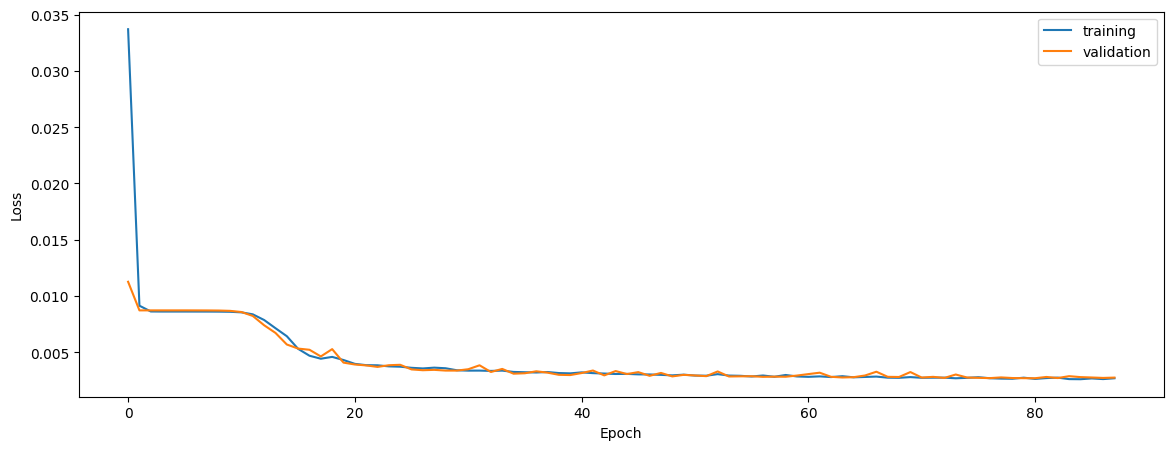

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8362435072045589
0.8315088672217475
0.8277647368318869


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8362435072045589
0.8315088672217475
0.8277647368318869


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8253516670992205
0.8341067866181465
0.8119505265312695


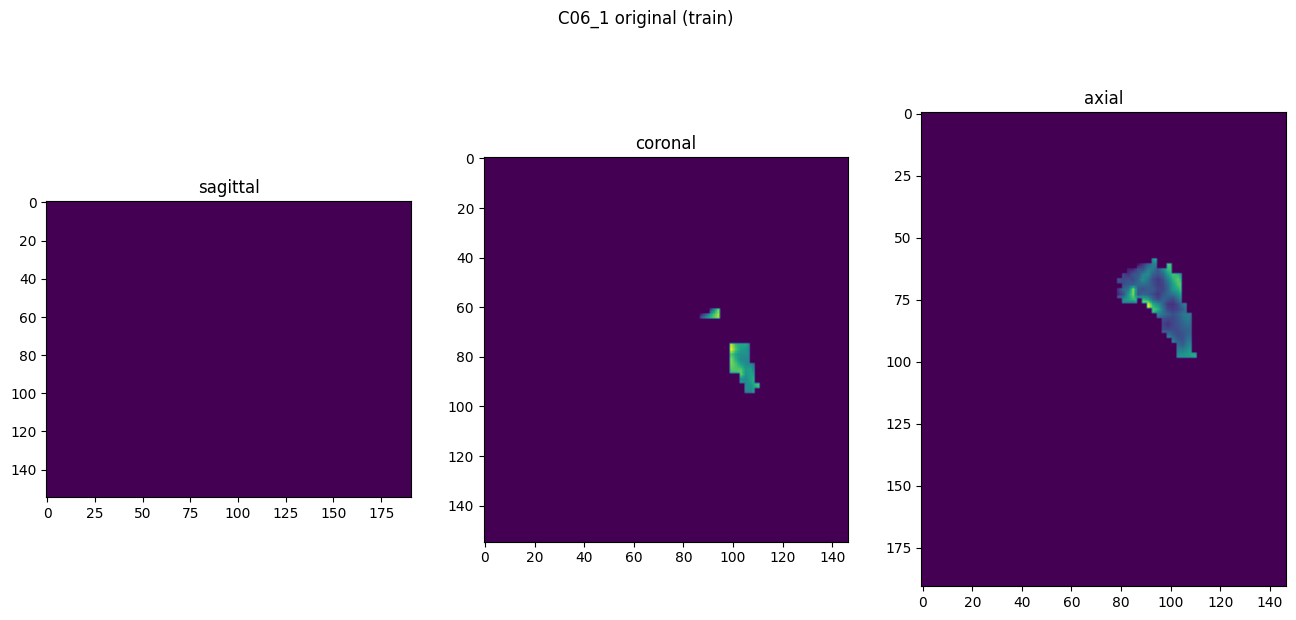

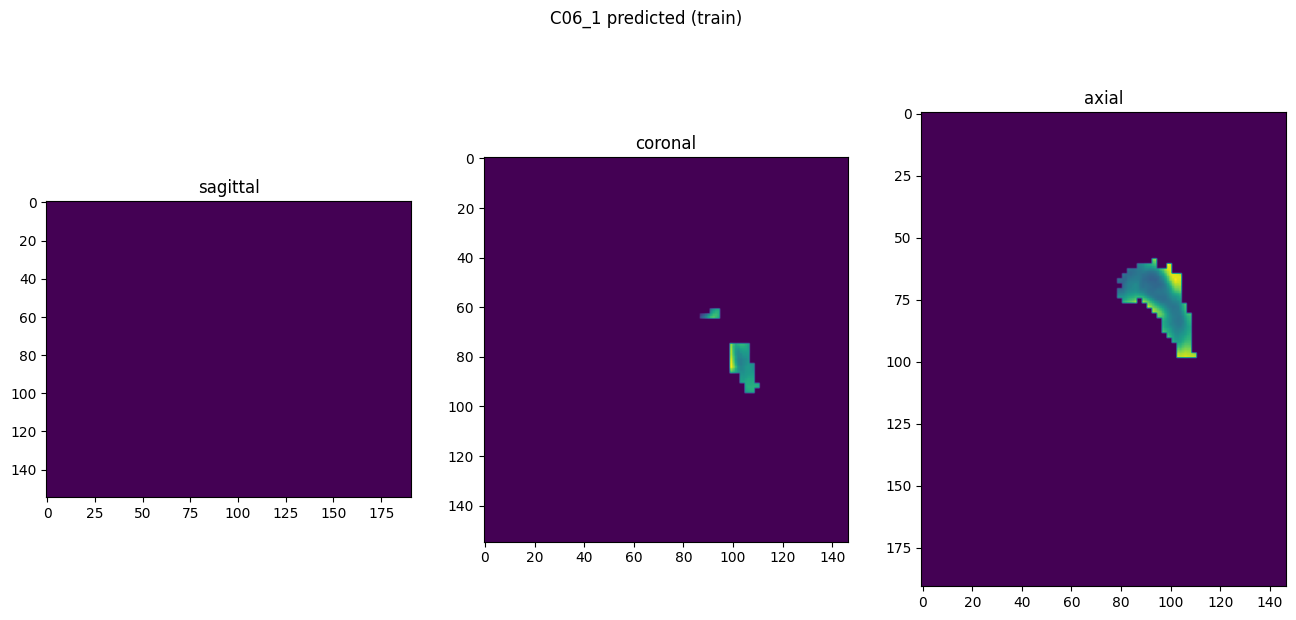

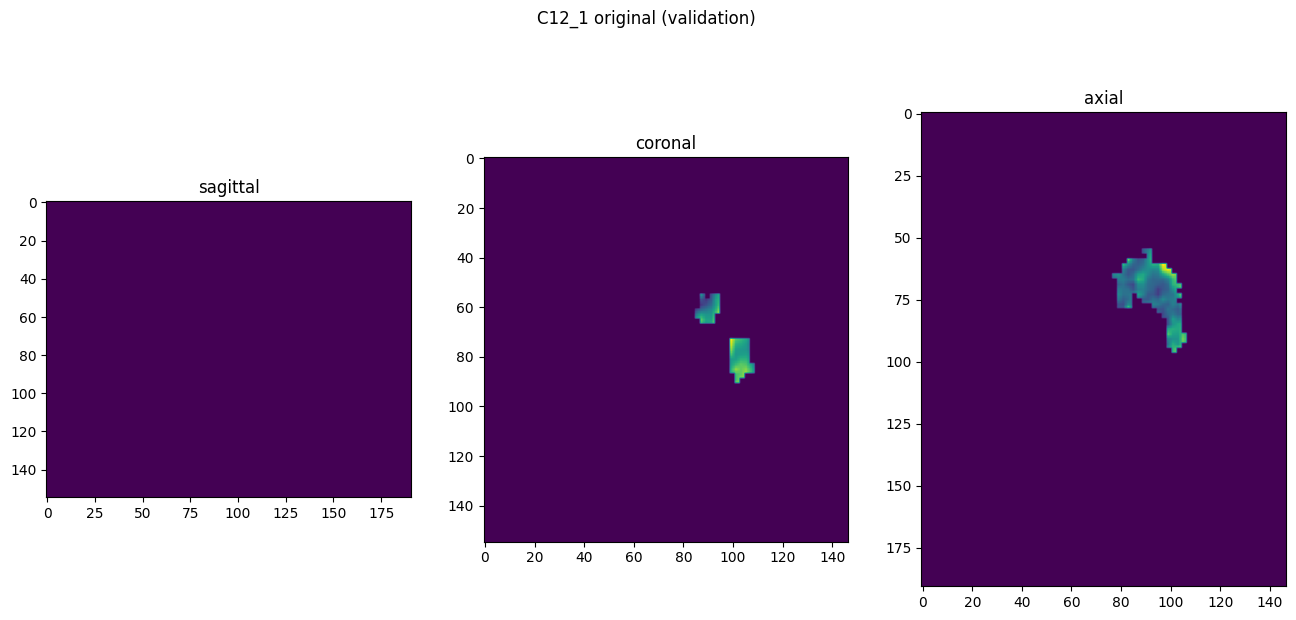

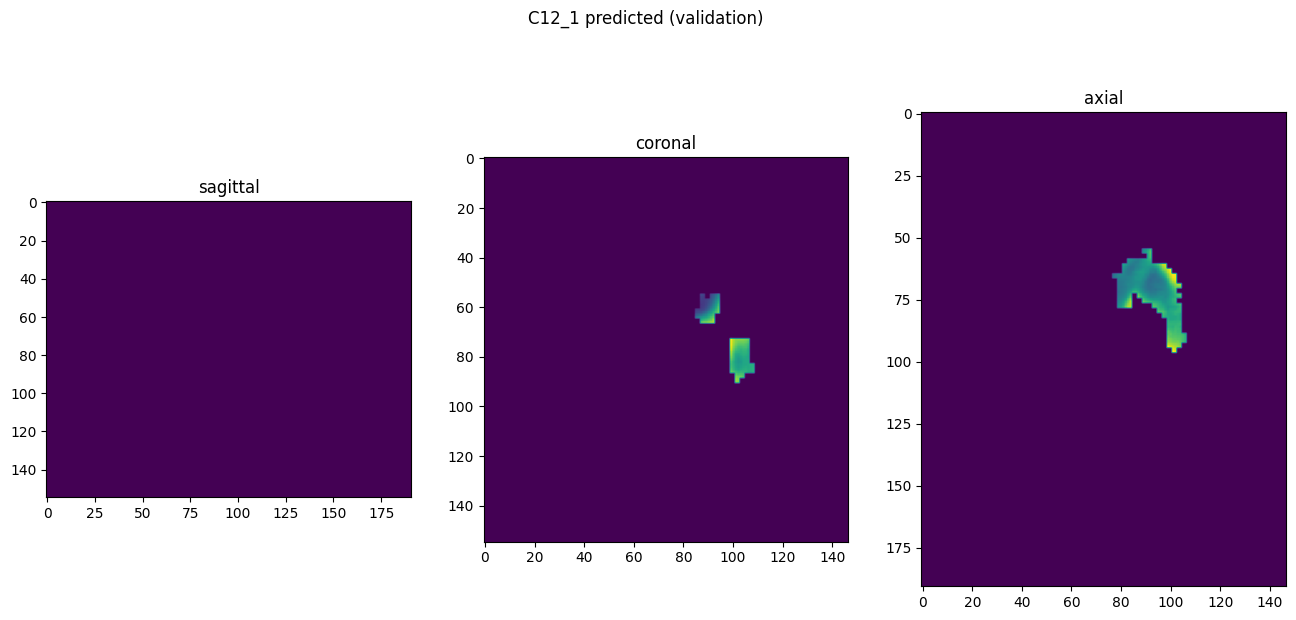

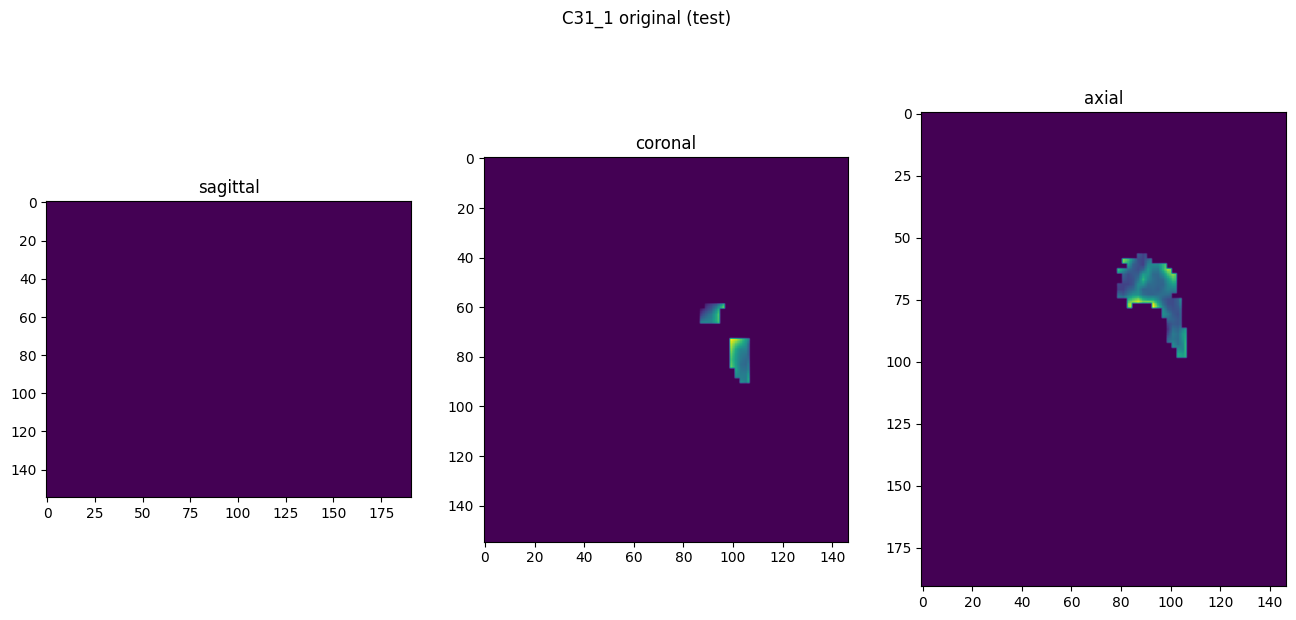

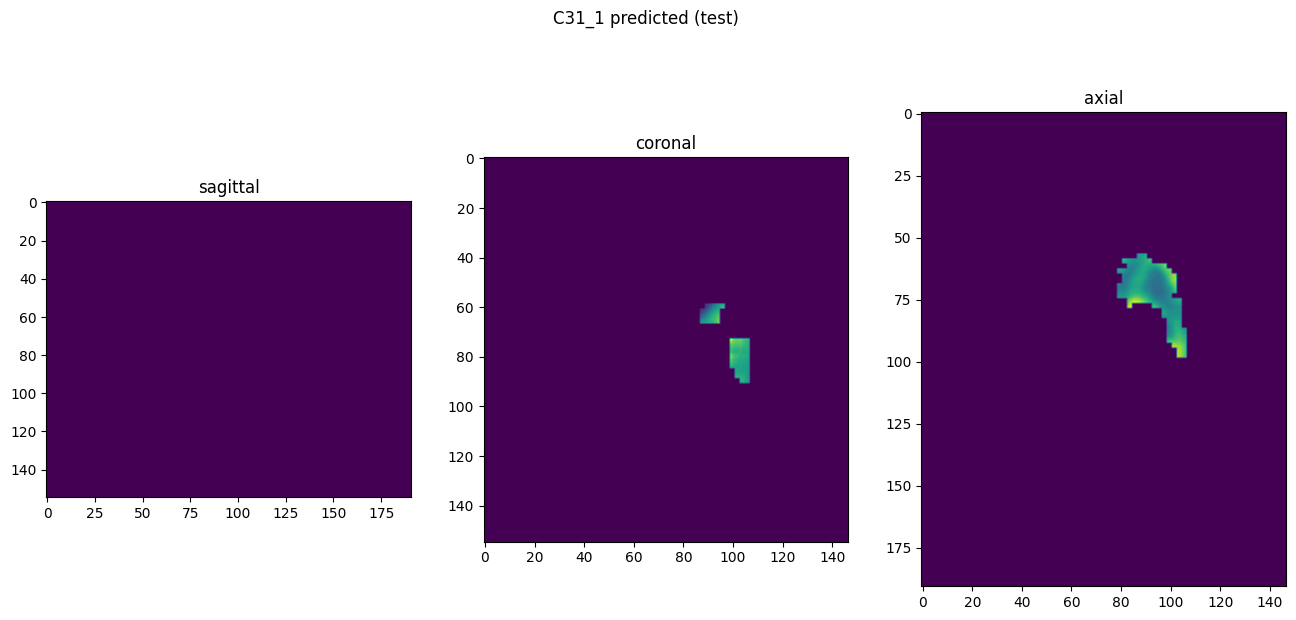

In [10]:
showResults(model, gen, threshold=None, background=False)